# Preface
The fourth phase of the Industrial Revolution is being driven by the Industrial Internet of Things, also referred to as Industry 4.0. This shift pushes industries toward smarter, connected operations and stronger competitiveness. A core goal of Industry 4.0 is higher asset uptime. More uptime raises productivity and reduces production and maintenance costs. A collection of factors, such as Artificial Intelligence and cyber-physical systems, has accelerated the growth of data-driven applications such as Predictive Maintenance (PdM).
Predictive maintenance means fixing a problem before it happens, instead of waiting for a breakdown. Think of a car dashboard light telling you to change the oil soon, not when your engine fails on the highway. For companies that manage industrial assets, unexpected failures become a top priority. Safety-critical systems such as turbofan engines demand reliable, intelligent maintenance. Predictive maintenance fits this need. It uses data, such as sensor readings of temperature and pressure, to plan maintenance ahead of time and avoid costly downtime.
A common approach is to predict the Remaining Useful Life (RUL) of components, meaning how much time is left before failure. This supports “just in time” maintenance and reduces the risk of disasters. For example, airlines want to estimate how many flights an engine can complete before service, so they can replace or repair it before any in-flight failure. Forecasting an engine’s health in advance is critical to safety and efficiency in aerospace operations.
In this case study, we walk through a real example using NASA’s simulated jet engine dataset (the Turbofan Engine Degradation Data) to predict when an engine will fail. We use the CRISP-DM data mining pipeline to structure the entire workflow, so each step in the paper maps to a CRISP-DM phase and feeds the next one. By the end of this paper, we show how data helps airlines avoid surprise engine failures.

## Business Understanding
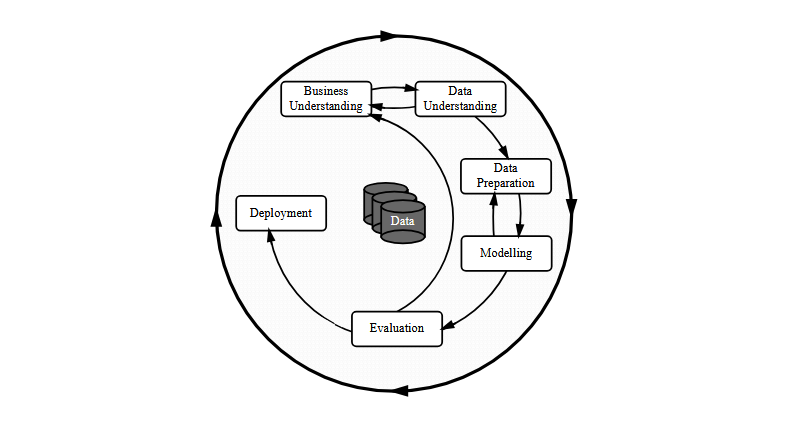

Airlines do not enjoy surprise engine failures. Engines also do not send polite emails like “Hi, I will fail next Tuesday at 14:00.” So the business goal behind predictive maintenance is simple: increase uptime, reduce maintenance cost, and avoid operational chaos, while keeping safety as the non-negotiable constraint. In an Industry 4.0 context, we treat turbofan engines as data-producing assets and use sensor readings to detect degradation early enough to plan maintenance before failure becomes downtime.

In this case study, the business question becomes a machine learning task: given an engine’s sensor history up to the last recorded cycle, estimate its Remaining Useful Life (RUL), meaning how many cycles are left until failure. The training data shows full run-to-failure trajectories, while the test data stops at a random point before failure, which matches the real situation: you never get the “failure timestamp” in advance, only the story so far. The aim is not to claim the ultimate solution. It is to build a clear, reproducible baseline in Python with scikit-learn, then evaluate whether the predictions are useful enough to support “just in time” maintenance decisions.

Before moving into Data Understanding in the CRISP-DM pipeline, I load the core libraries and set a couple of small display settings so tables and outputs stay readable.


In [1]:
import seaborn as sns
import os
import pandas as pd
import numpy as np
np.random.seed(1337)
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

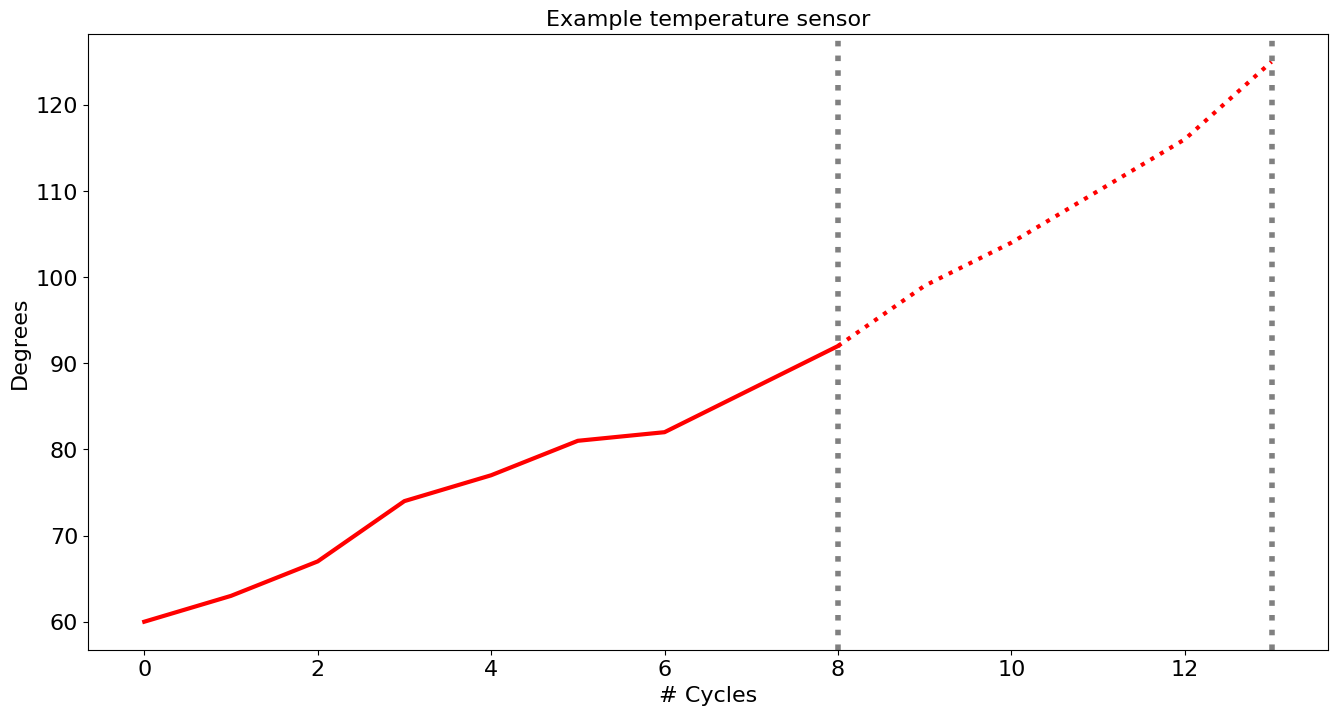

In [3]:
A=[60,63,67,74,77,81,82,87,92]
B=[92,99,104,110,116,125]
C = np.append(np.repeat(np.nan, len(A)-1), B)
plt.figure(figsize = (16, 8))
plt.plot(A, color='red', linewidth=3)
plt.plot(C, 'r:', linewidth=3)
plt.axvline(x=len(A)-1, color='grey', linestyle=':', linewidth=4)
plt.axvline(x=len(C)-1, color='grey', linestyle=':', linewidth=4)
plt.title('Example temperature sensor', fontsize=16)
plt.xlabel('# Cycles', fontsize=16)
plt.ylabel('Degrees', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Data Understanding

## Data Overview
Now I want to meet the data and check if it looks like a well-behaved dataset or like a suitcase packed at 3 a.m. The goal here is simple: load the three files, check their structure, and confirm what each one represents.

First, I load the datasets. I use one training set, one test set, and one target file containing the true RUL values for the test engines.

In [4]:
cols = ["unit","cycles","op_setting1","op_setting2","op_setting3"] + [f"s{i}" for i in range(1, 22)]

train = pd.read_csv("data/train_FD001.txt", sep=r"\s+", header=None, names=cols).dropna(axis=1, how="all")
test  = pd.read_csv("data/test_FD001.txt",  sep=r"\s+", header=None, names=cols).dropna(axis=1, how="all")
RUL   = pd.read_csv("data/RUL_FD001.txt",   sep=r"\s+", header=None, names=["RUL"])


Now I use the following lines to see the size of the training set and the column names, so I know what kind of features I am working with.

In [5]:
print(train.shape)
print(list(train.columns))

(20631, 26)
['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


The training data contains 26 columns. Two are identifiers (`unit`, `cycles`), three are operational settings (`op_setting1–3`), and the rest are sensor readings (`s1–s21`). In other words: each row is one engine at one cycle, with the engine’s “vital signs” recorded like a hospital chart, but for turbines.

Next, I check missing values. Missing values in sensor data often turn into silent model damage later, so I want to catch them early.

In [6]:
train.isna().sum()

unit           0
cycles         0
op_setting1    0
op_setting2    0
op_setting3    0
s1             0
s2             0
s3             0
s4             0
s5             0
s6             0
s7             0
s8             0
s9             0
s10            0
s11            0
s12            0
s13            0
s14            0
s15            0
s16            0
s17            0
s18            0
s19            0
s20            0
s21            0
dtype: int64

The output shows no missing values in the training set, which is rare in real life and suspiciously convenient. Since this dataset is simulated, I accept the gift and move on.

I also preview the first and last rows. This confirms that `cycles` increases per `unit` and gives a quick sanity check on the values.


In [7]:
train.head()

unit  cycles  op_setting1  op_setting2  op_setting3      s1      s2  \
0     1       1       -0.001       -0.000      100.000 518.670 641.820   
1     1       2        0.002       -0.000      100.000 518.670 642.150   
2     1       3       -0.004        0.000      100.000 518.670 642.350   
3     1       4        0.001        0.000      100.000 518.670 642.350   
4     1       5       -0.002       -0.000      100.000 518.670 642.370   

        s3       s4     s5  ...     s12      s13      s14   s15   s16  s17  \
0 1589.700 1400.600 14.620  ... 521.660 2388.020 8138.620 8.419 0.030  392   
1 1591.820 1403.140 14.620  ... 522.280 2388.070 8131.490 8.432 0.030  392   
2 1587.990 1404.200 14.620  ... 522.420 2388.030 8133.230 8.418 0.030  390   
3 1582.790 1401.870 14.620  ... 522.860 2388.080 8133.830 8.368 0.030  392   
4 1582.850 1406.220 14.620  ... 522.190 2388.040 8133.800 8.429 0.030  393   

    s18     s19    s20    s21  
0  2388 100.000 39.060 23.419  
1  2388 100.000 39.000 23.424  
2  2388 100.000 38.950 23.344  
3  2388 100.000 38.880 23.374  
4  2388 100.000 38.900 23.404  

[5 rows x 26 columns]

In [8]:
train.tail()

unit  cycles  op_setting1  op_setting2  op_setting3      s1      s2  \
20626   100     196       -0.000       -0.000      100.000 518.670 643.490   
20627   100     197       -0.002       -0.001      100.000 518.670 643.540   
20628   100     198        0.000        0.000      100.000 518.670 643.420   
20629   100     199       -0.001        0.000      100.000 518.670 643.230   
20630   100     200       -0.003       -0.001      100.000 518.670 643.850   

            s3       s4     s5  ...     s12      s13      s14   s15   s16  \
20626 1597.980 1428.630 14.620  ... 519.490 2388.260 8137.600 8.496 0.030   
20627 1604.500 1433.580 14.620  ... 519.680 2388.220 8136.500 8.514 0.030   
20628 1602.460 1428.180 14.620  ... 520.010 2388.240 8141.050 8.565 0.030   
20629 1605.260 1426.530 14.620  ... 519.670 2388.230 8139.290 8.539 0.030   
20630 1600.380 1432.140 14.620  ... 519.300 2388.260 8137.330 8.504 0.030   

       s17   s18     s19    s20    s21  
20626  397  2388 100.000 38.490 22.974  
20627  395  2388 100.000 38.300 23.159  
20628  398  2388 100.000 38.440 22.933  
20629  395  2388 100.000 38.290 23.064  
20630  396  2388 100.000 38.370 23.052  

[5 rows x 26 columns]

Then I repeat the same inspection for the test set.

In [9]:
print(test.shape)
print(list(test.columns))

(13096, 26)
['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [10]:
test.isna().sum()

unit           0
cycles         0
op_setting1    0
op_setting2    0
op_setting3    0
s1             0
s2             0
s3             0
s4             0
s5             0
s6             0
s7             0
s8             0
s9             0
s10            0
s11            0
s12            0
s13            0
s14            0
s15            0
s16            0
s17            0
s18            0
s19            0
s20            0
s21            0
dtype: int64

In [11]:
test.head()

unit  cycles  op_setting1  op_setting2  op_setting3      s1      s2  \
0     1       1        0.002        0.000      100.000 518.670 643.020   
1     1       2       -0.003       -0.000      100.000 518.670 641.710   
2     1       3        0.000        0.000      100.000 518.670 642.460   
3     1       4        0.004        0.000      100.000 518.670 642.440   
4     1       5        0.001        0.000      100.000 518.670 642.510   

        s3       s4     s5  ...     s12      s13      s14   s15   s16  s17  \
0 1585.290 1398.210 14.620  ... 521.720 2388.030 8125.550 8.405 0.030  392   
1 1588.450 1395.420 14.620  ... 522.160 2388.060 8139.620 8.380 0.030  393   
2 1586.940 1401.340 14.620  ... 521.970 2388.030 8130.100 8.444 0.030  393   
3 1584.120 1406.420 14.620  ... 521.380 2388.050 8132.900 8.392 0.030  391   
4 1587.190 1401.920 14.620  ... 522.150 2388.030 8129.540 8.403 0.030  390   

    s18     s19    s20    s21  
0  2388 100.000 38.860 23.373  
1  2388 100.000 39.020 23.392  
2  2388 100.000 39.080 23.417  
3  2388 100.000 39.000 23.374  
4  2388 100.000 38.990 23.413  

[5 rows x 26 columns]

In [12]:
test.tail()

unit  cycles  op_setting1  op_setting2  op_setting3      s1      s2  \
13091   100     194        0.005        0.000      100.000 518.670 643.240   
13092   100     195       -0.001       -0.000      100.000 518.670 643.220   
13093   100     196       -0.001       -0.000      100.000 518.670 643.440   
13094   100     197       -0.004        0.000      100.000 518.670 643.260   
13095   100     198        0.001        0.000      100.000 518.670 642.950   

            s3       s4     s5  ...     s12      s13      s14   s15   s16  \
13091 1599.450 1415.790 14.620  ... 520.690 2388.000 8213.280 8.472 0.030   
13092 1595.690 1422.050 14.620  ... 521.050 2388.090 8210.850 8.451 0.030   
13093 1593.150 1406.820 14.620  ... 521.180 2388.040 8217.240 8.457 0.030   
13094 1594.990 1419.360 14.620  ... 521.330 2388.080 8220.480 8.471 0.030   
13095 1601.620 1424.990 14.620  ... 521.070 2388.050 8214.640 8.490 0.030   

       s17   s18     s19    s20    s21  
13091  394  2388 100.000 38.650 23.197  
13092  395  2388 100.000 38.570 23.277  
13093  395  2388 100.000 38.620 23.205  
13094  395  2388 100.000 38.660 23.270  
13095  396  2388 100.000 38.700 23.186  

[5 rows x 26 columns]

The test set has the same 26 columns, but fewer rows because each engine stops at a random time before failure. This matches the real business situation: you never see the failure point in advance, you only see “up to now.”

Finally, I inspect the RUL target file. This contains the true remaining cycles for each test engine, used later to evaluate predictions.

In [13]:
print(RUL.shape)
print(list(RUL.columns))

(100, 1)
['RUL']


In [14]:
RUL.isna().sum()

RUL    0
dtype: int64

In [15]:
RUL.head()

RUL
0  112
1   98
2   69
3   82
4   91

In [16]:
RUL.tail()

RUL
95  137
96   82
97   59
98  117
99   20

At this point, the data story is clear. The model will learn from full run-to-failure histories in the training set, then predict the remaining cycles for each unit in the test set, and I will compare those predictions against the RUL file.

To get a feeling for the target distribution, I plot it and print basic descriptive statistics.

<Axes: xlabel='RUL', ylabel='Count'>

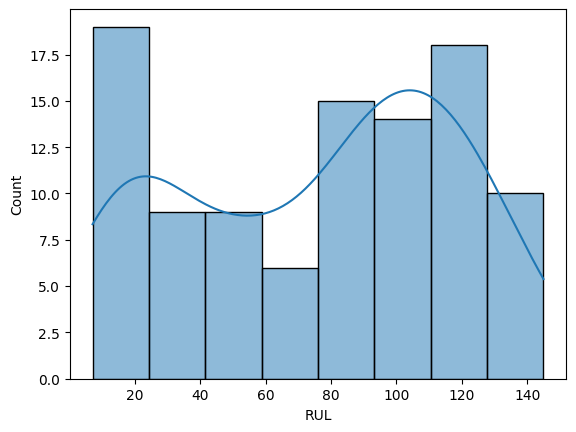

In [17]:
sns.histplot(RUL['RUL'],kde=True)

In [18]:
RUL['RUL'].describe()

count   100.000
mean     75.520
std      41.765
min       7.000
25%      32.750
50%      86.000
75%     112.250
max     145.000
Name: RUL, dtype: float64

## Checking for Outliers and Flat Lines
Now I want to know two things. Do any sensors contain extreme values that look unrealistic, and do any sensors stay constant over time. A constant sensor is a “flat line,” which is the sensor equivalent of a coworker who clocks in and then disappears.

I start with descriptive statistics to see ranges, means, and standard deviations.

In [19]:
train.describe().T

count     mean    std      min      25%      50%      75%  \
unit        20631.000   51.507 29.228    1.000   26.000   52.000   77.000   
cycles      20631.000  108.808 68.881    1.000   52.000  104.000  156.000   
op_setting1 20631.000   -0.000  0.002   -0.009   -0.002    0.000    0.002   
op_setting2 20631.000    0.000  0.000   -0.001   -0.000    0.000    0.000   
op_setting3 20631.000  100.000  0.000  100.000  100.000  100.000  100.000   
s1          20631.000  518.670  0.000  518.670  518.670  518.670  518.670   
s2          20631.000  642.681  0.500  641.210  642.325  642.640  643.000   
s3          20631.000 1590.523  6.131 1571.040 1586.260 1590.100 1594.380   
s4          20631.000 1408.934  9.001 1382.250 1402.360 1408.040 1414.555   
s5          20631.000   14.620  0.000   14.620   14.620   14.620   14.620   
s6          20631.000   21.610  0.001   21.600   21.610   21.610   21.610   
s7          20631.000  553.368  0.885  549.850  552.810  553.440  554.010   
s8          20631.000 2388.097  0.071 2387.900 2388.050 2388.090 2388.140   
s9          20631.000 9065.243 22.083 9021.730 9053.100 9060.660 9069.420   
s10         20631.000    1.300  0.000    1.300    1.300    1.300    1.300   
s11         20631.000   47.541  0.267   46.850   47.350   47.510   47.700   
s12         20631.000  521.413  0.738  518.690  520.960  521.480  521.950   
s13         20631.000 2388.096  0.072 2387.880 2388.040 2388.090 2388.140   
s14         20631.000 8143.753 19.076 8099.940 8133.245 8140.540 8148.310   
s15         20631.000    8.442  0.038    8.325    8.415    8.439    8.466   
s16         20631.000    0.030  0.000    0.030    0.030    0.030    0.030   
s17         20631.000  393.211  1.549  388.000  392.000  393.000  394.000   
s18         20631.000 2388.000  0.000 2388.000 2388.000 2388.000 2388.000   
s19         20631.000  100.000  0.000  100.000  100.000  100.000  100.000   
s20         20631.000   38.816  0.181   38.140   38.700   38.830   38.950   
s21         20631.000   23.290  0.108   22.894   23.222   23.298   23.367   

                 max  
unit         100.000  
cycles       362.000  
op_setting1    0.009  
op_setting2    0.001  
op_setting3  100.000  
s1           518.670  
s2           644.530  
s3          1616.910  
s4          1441.490  
s5            14.620  
s6            21.610  
s7           556.060  
s8          2388.560  
s9          9244.590  
s10            1.300  
s11           48.530  
s12          523.380  
s13         2388.560  
s14         8293.720  
s15            8.585  
s16            0.030  
s17          400.000  
s18         2388.000  
s19          100.000  
s20           39.430  
s21           23.618

In [20]:
test.describe().T

count     mean    std      min      25%      50%      75%  \
unit        13096.000   51.544 28.289    1.000   28.000   52.000   76.000   
cycles      13096.000   76.837 53.058    1.000   33.000   69.000  113.000   
op_setting1 13096.000   -0.000  0.002   -0.008   -0.002   -0.000    0.002   
op_setting2 13096.000    0.000  0.000   -0.001   -0.000   -0.000    0.000   
op_setting3 13096.000  100.000  0.000  100.000  100.000  100.000  100.000   
s1          13096.000  518.670  0.000  518.670  518.670  518.670  518.670   
s2          13096.000  642.475  0.401  641.130  642.197  642.460  642.740   
s3          13096.000 1588.099  5.003 1569.040 1584.600 1587.990 1591.362   
s4          13096.000 1404.735  6.688 1384.390 1399.950 1404.440 1409.050   
s5          13096.000   14.620  0.000   14.620   14.620   14.620   14.620   
s6          13096.000   21.610  0.002   21.600   21.610   21.610   21.610   
s7          13096.000  553.758  0.681  550.880  553.310  553.800  554.240   
s8          13096.000 2388.071  0.057 2387.890 2388.030 2388.070 2388.110   
s9          13096.000 9058.407 11.436 9024.530 9051.020 9057.320 9064.110   
s10         13096.000    1.300  0.000    1.300    1.300    1.300    1.300   
s11         13096.000   47.416  0.196   46.800   47.270   47.410   47.540   
s12         13096.000  521.748  0.560  519.380  521.380  521.780  522.150   
s13         13096.000 2388.071  0.057 2387.890 2388.030 2388.070 2388.110   
s14         13096.000 8138.948 10.189 8108.500 8132.310 8138.390 8144.360   
s15         13096.000    8.426  0.029    8.333    8.406    8.425    8.444   
s16         13096.000    0.030  0.000    0.030    0.030    0.030    0.030   
s17         13096.000  392.572  1.234  389.000  392.000  393.000  393.000   
s18         13096.000 2388.000  0.000 2388.000 2388.000 2388.000 2388.000   
s19         13096.000  100.000  0.000  100.000  100.000  100.000  100.000   
s20         13096.000   38.893  0.142   38.310   38.800   38.900   38.990   
s21         13096.000   23.336  0.084   22.935   23.282   23.339   23.394   

                 max  
unit         100.000  
cycles       303.000  
op_setting1    0.008  
op_setting2    0.001  
op_setting3  100.000  
s1           518.670  
s2           644.300  
s3          1607.550  
s4          1433.360  
s5            14.620  
s6            21.610  
s7           555.840  
s8          2388.300  
s9          9155.030  
s10            1.300  
s11           48.260  
s12          523.760  
s13         2388.320  
s14         8220.480  
s15            8.541  
s16            0.030  
s17          397.000  
s18         2388.000  
s19          100.000  
s20           39.410  
s21           23.642

Extreme outliers would show up as huge gaps between min and max compared with the rest of the distribution. Here, nothing jumps out as absurd.

Then I look for flat lines. A flat line shows up as standard deviation equal to zero, or as a column with only one unique value. It can also be shown as a constant value.

I also verify the same issue inside the test set, because consistency matters when I drop columns.

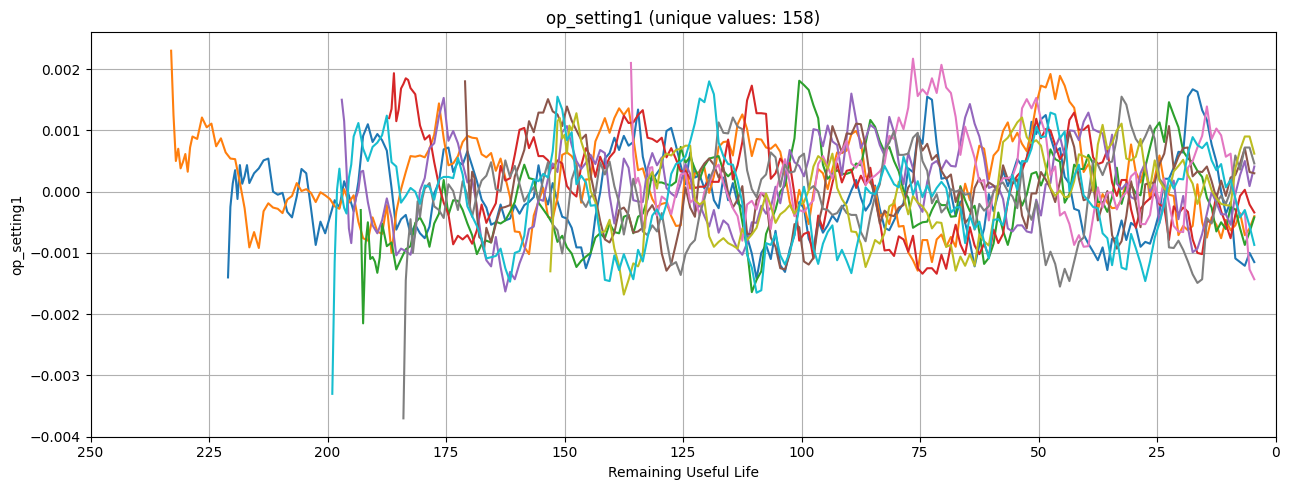

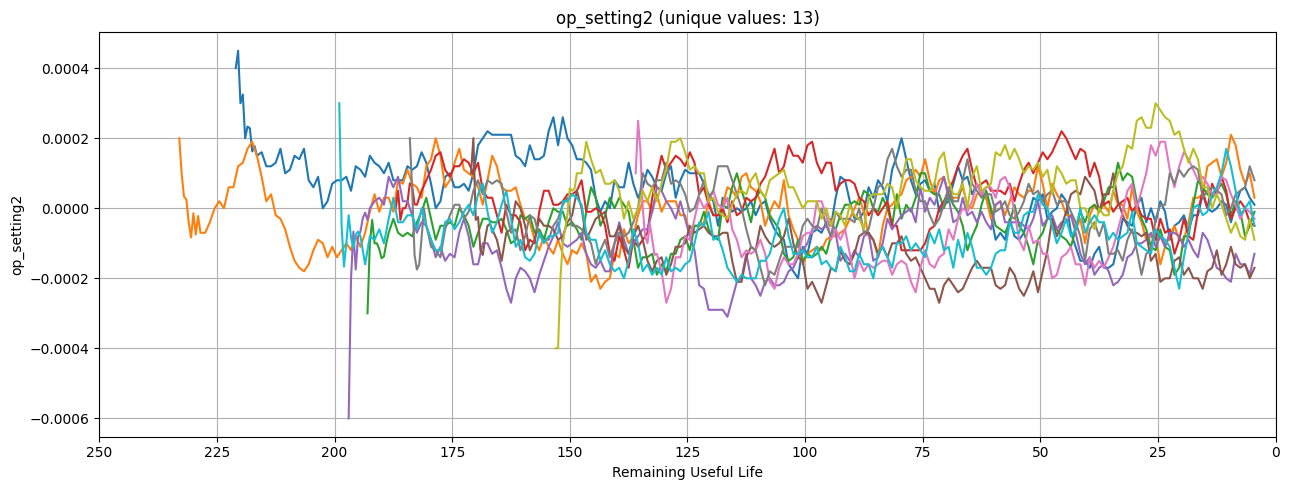

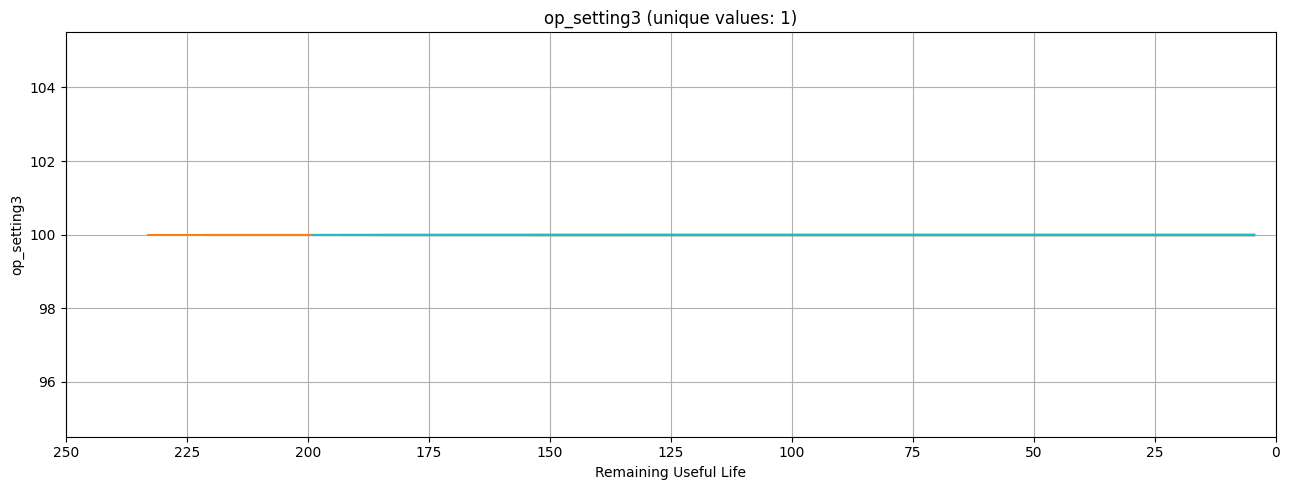

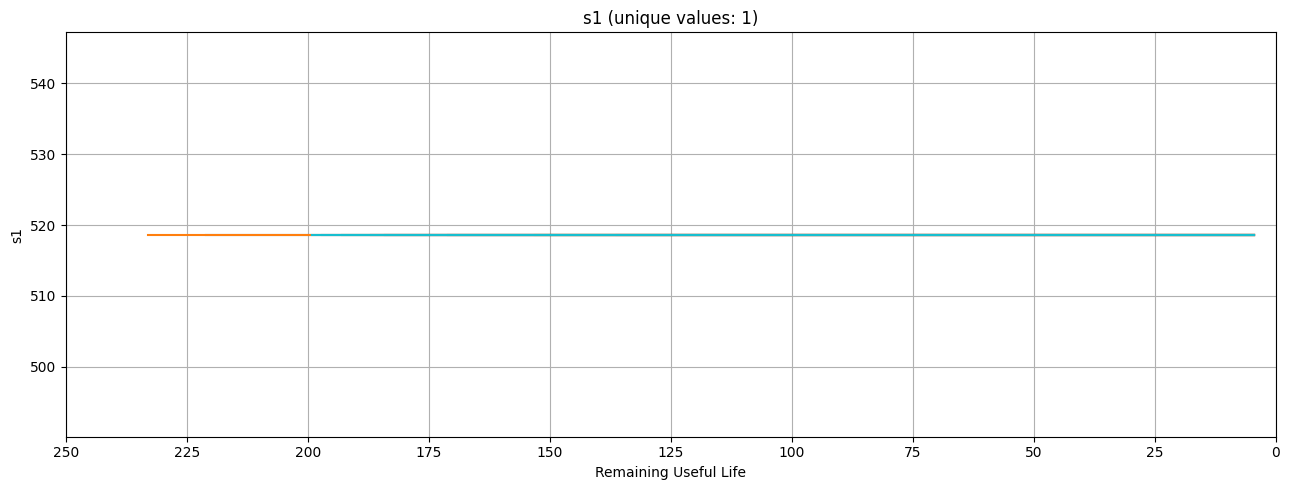

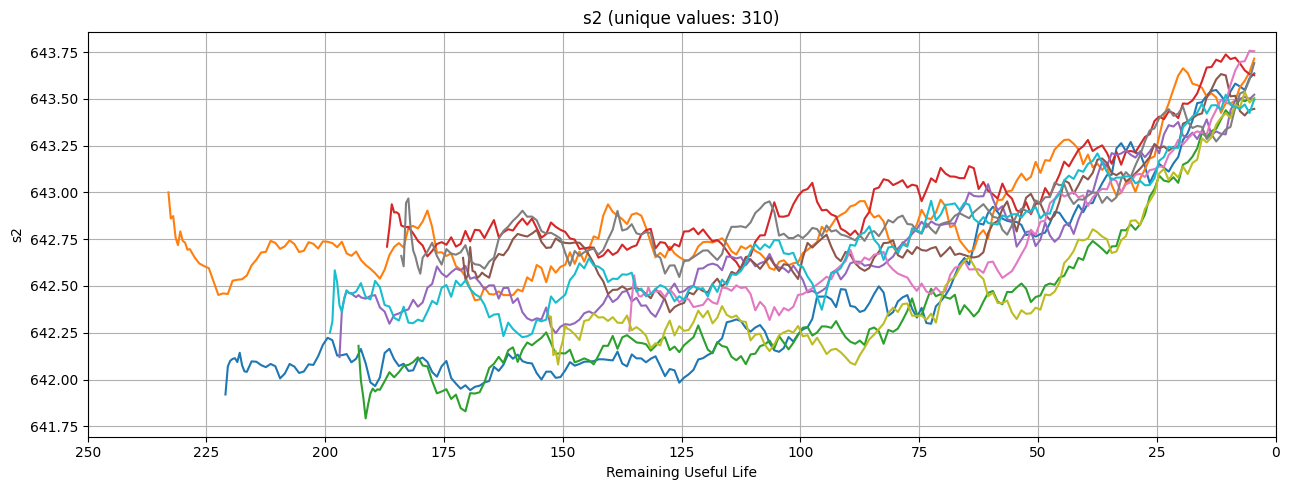

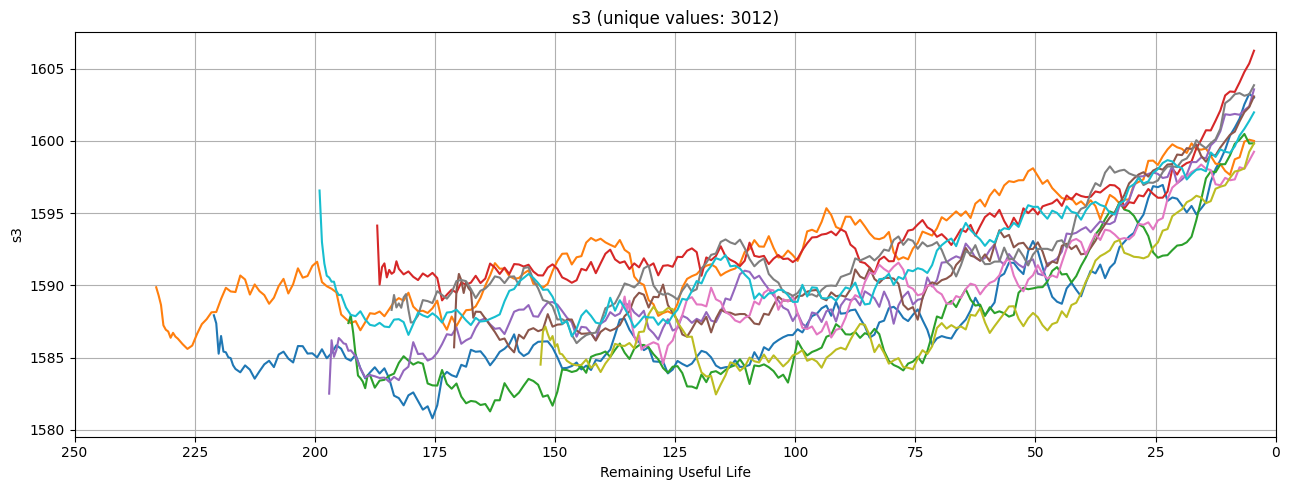

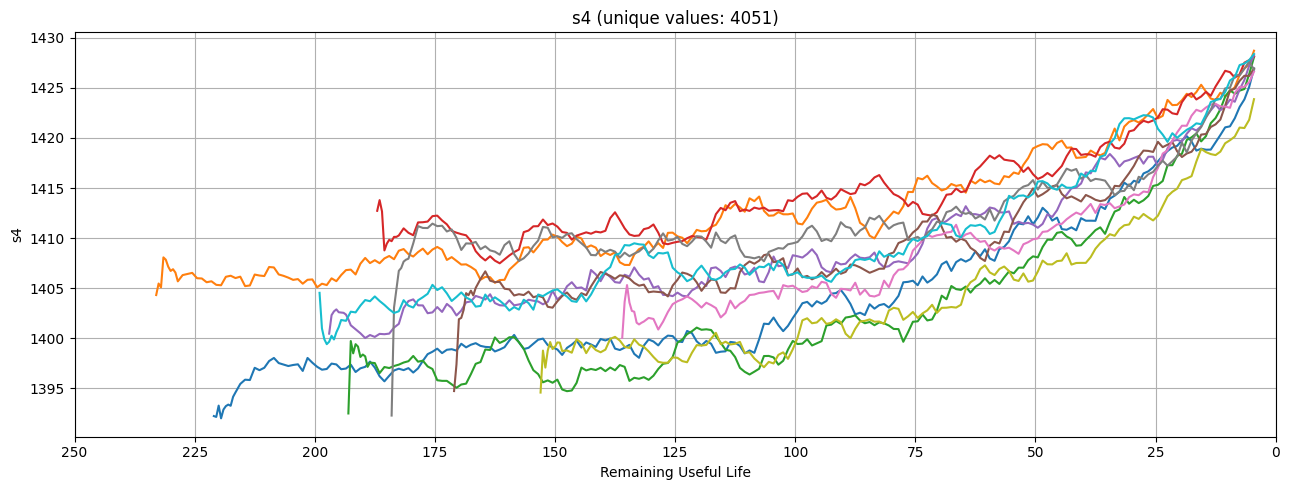

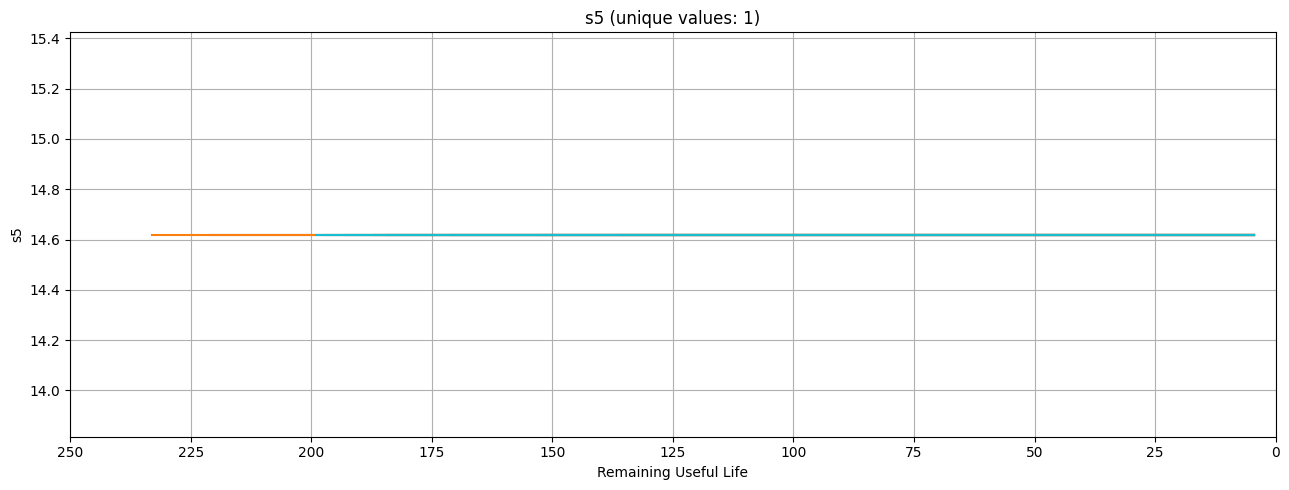

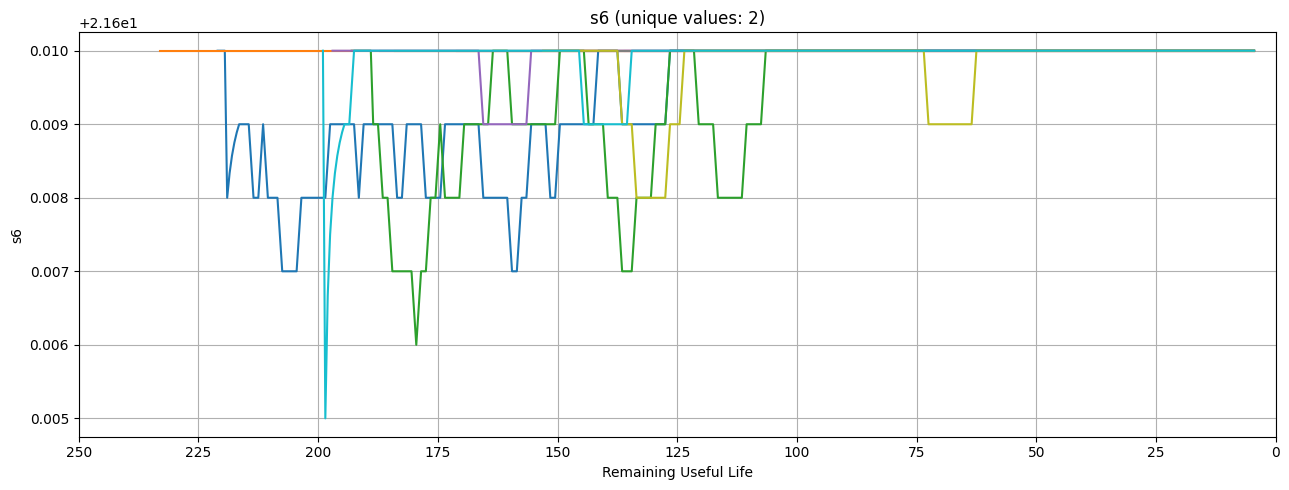

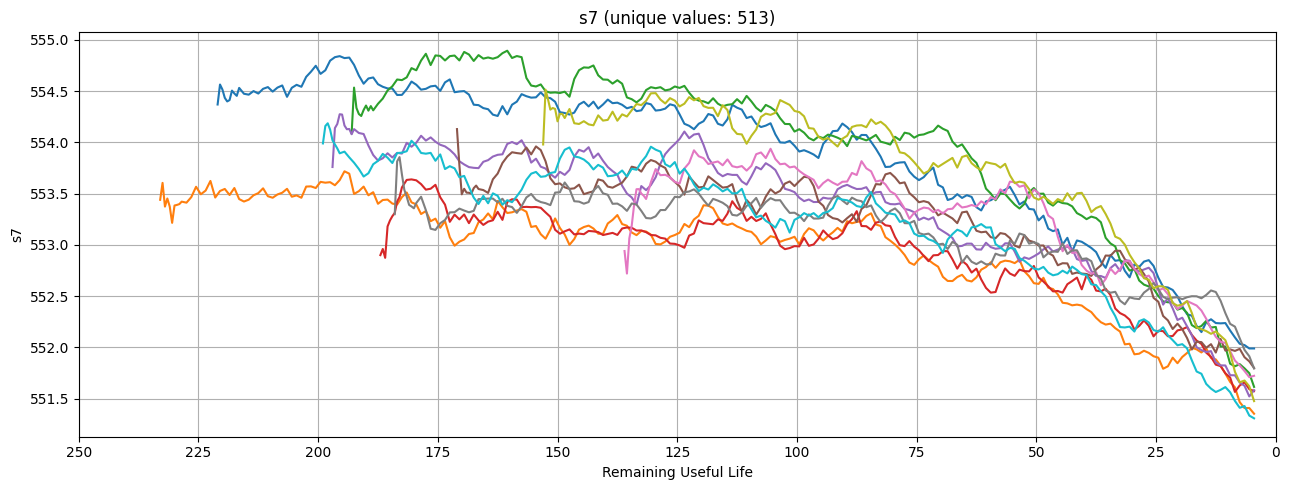

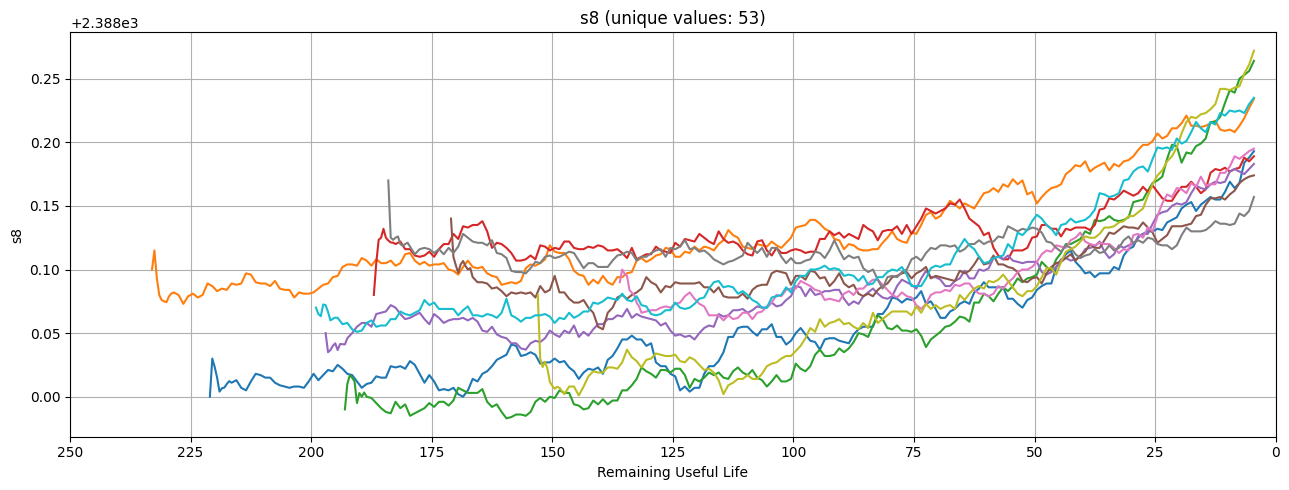

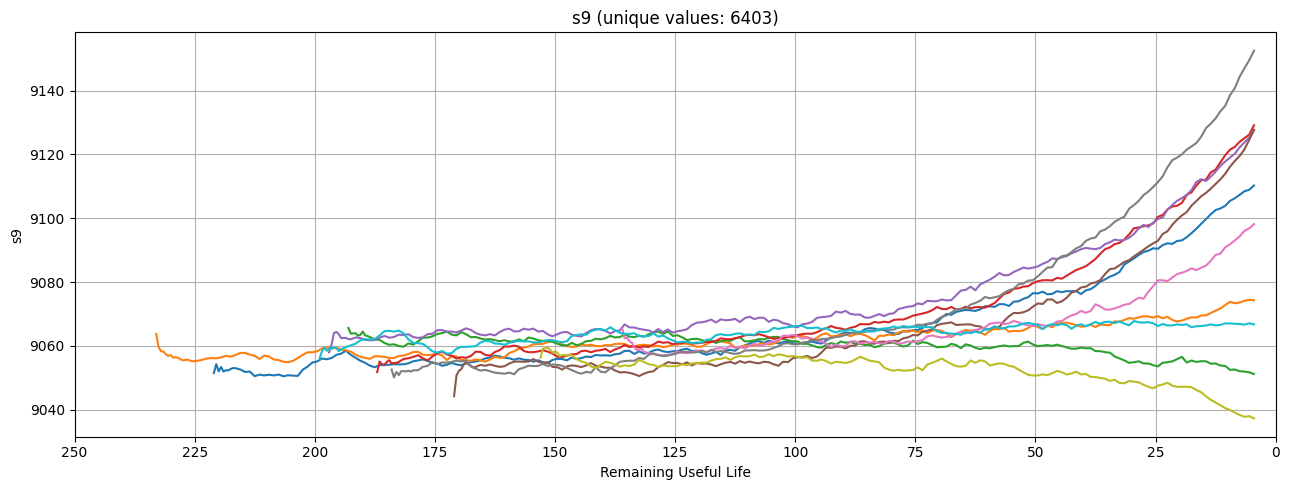

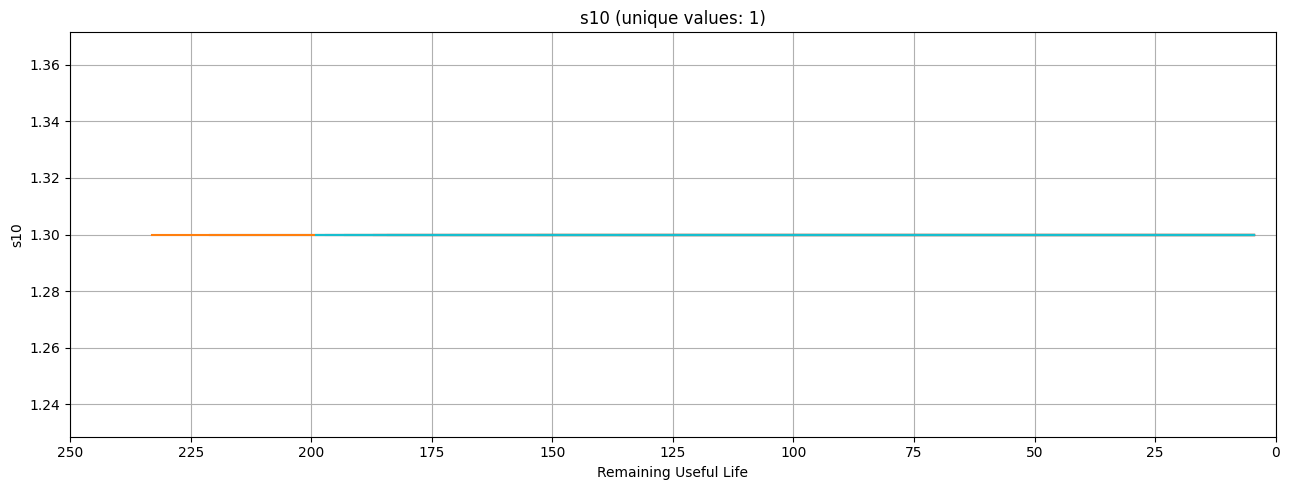

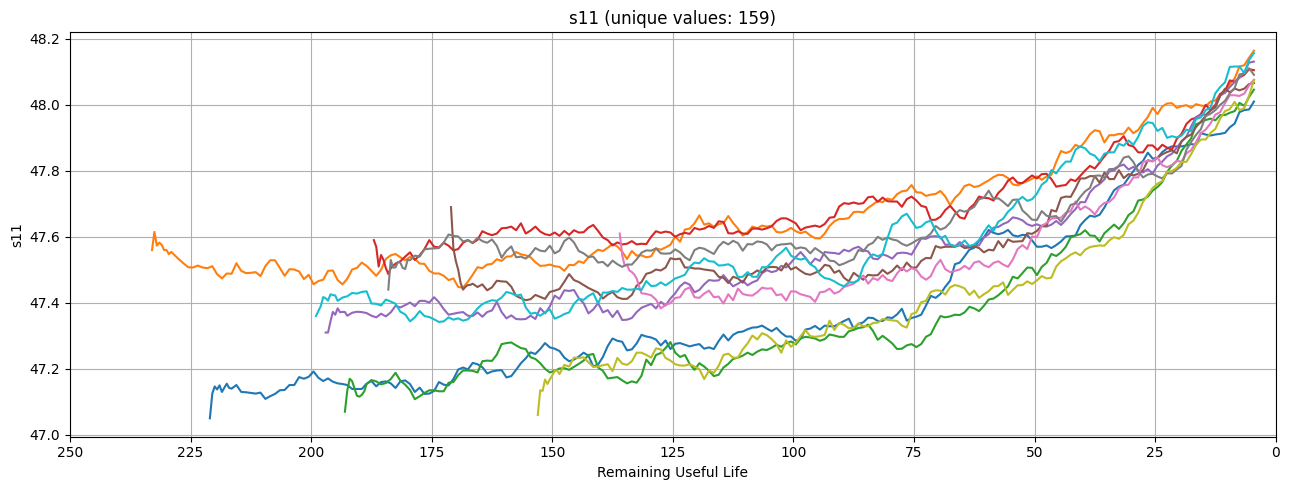

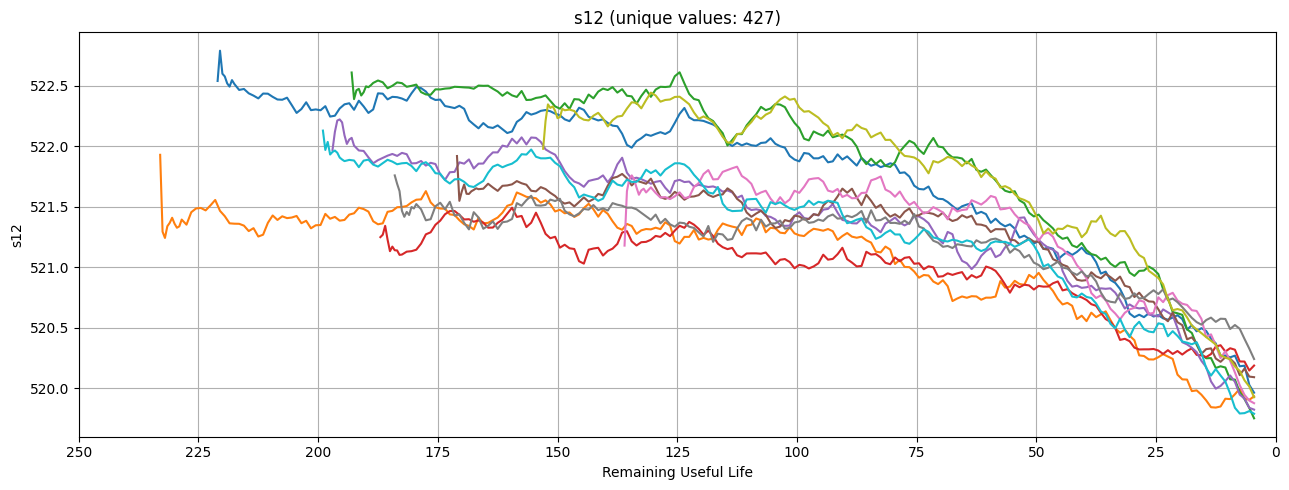

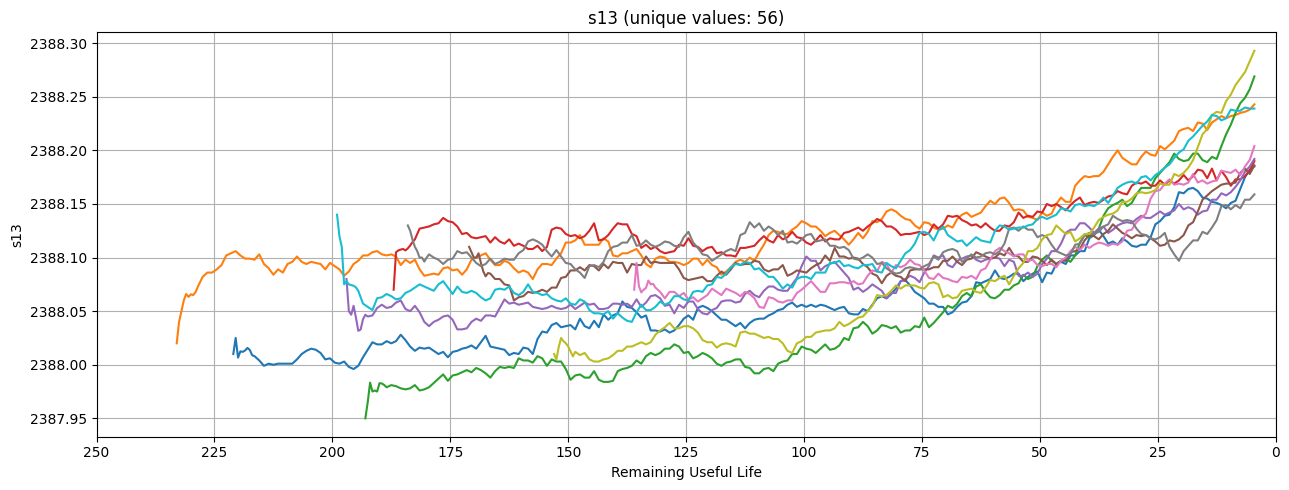

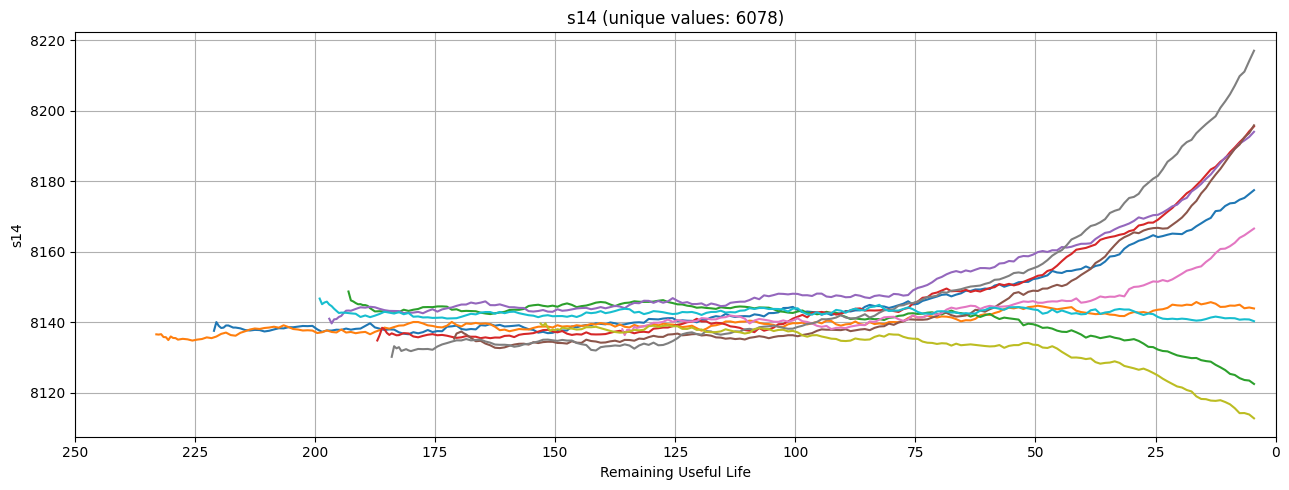

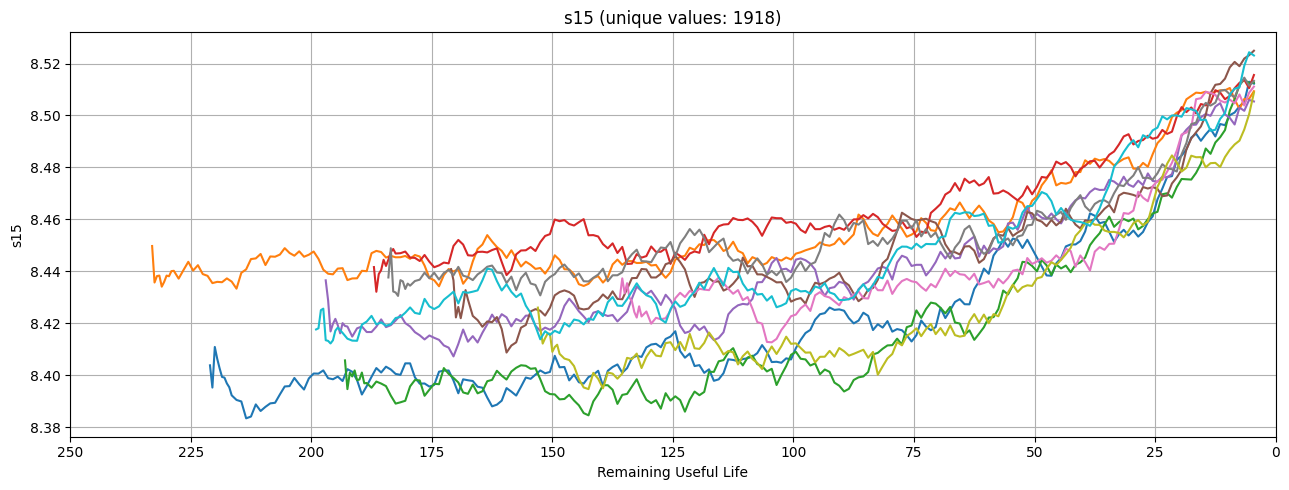

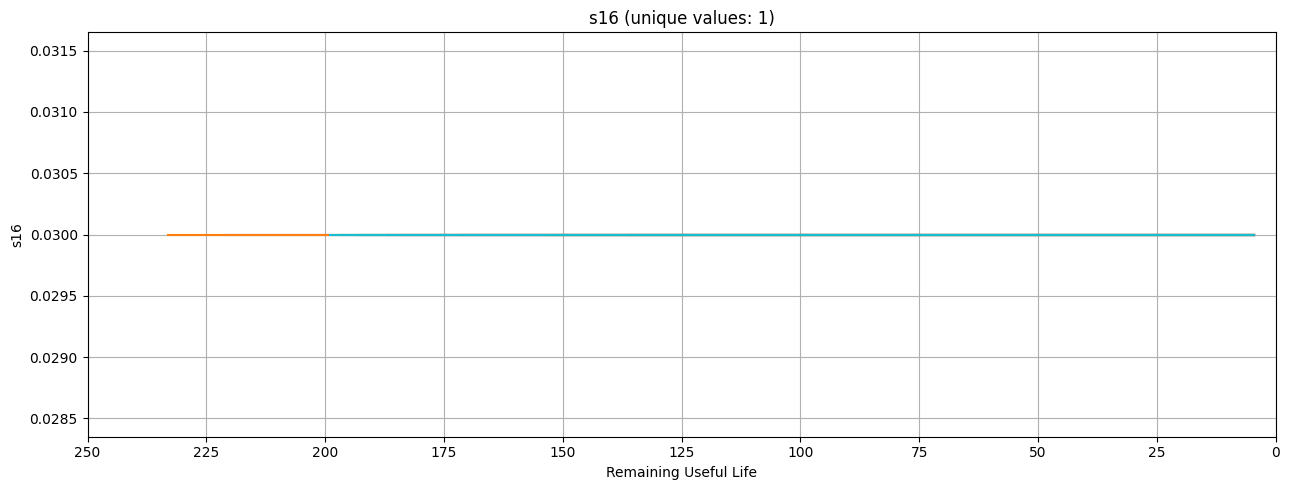

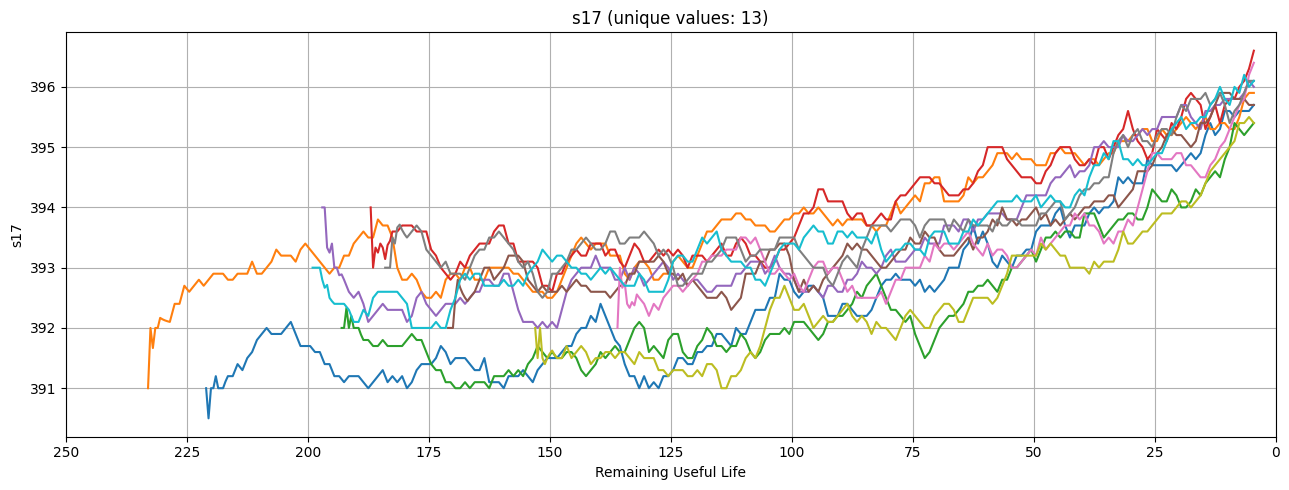

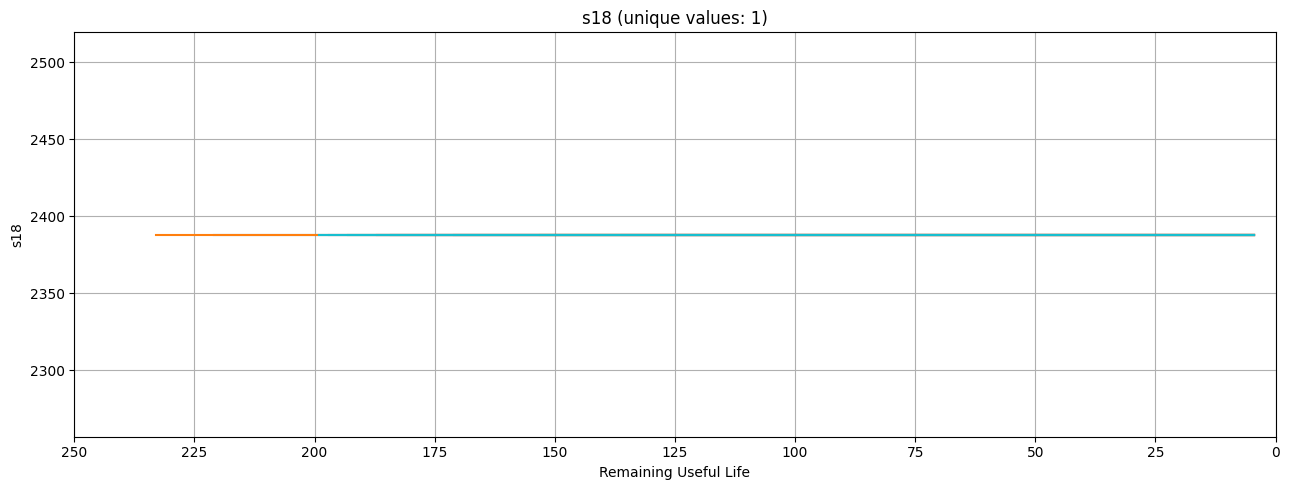

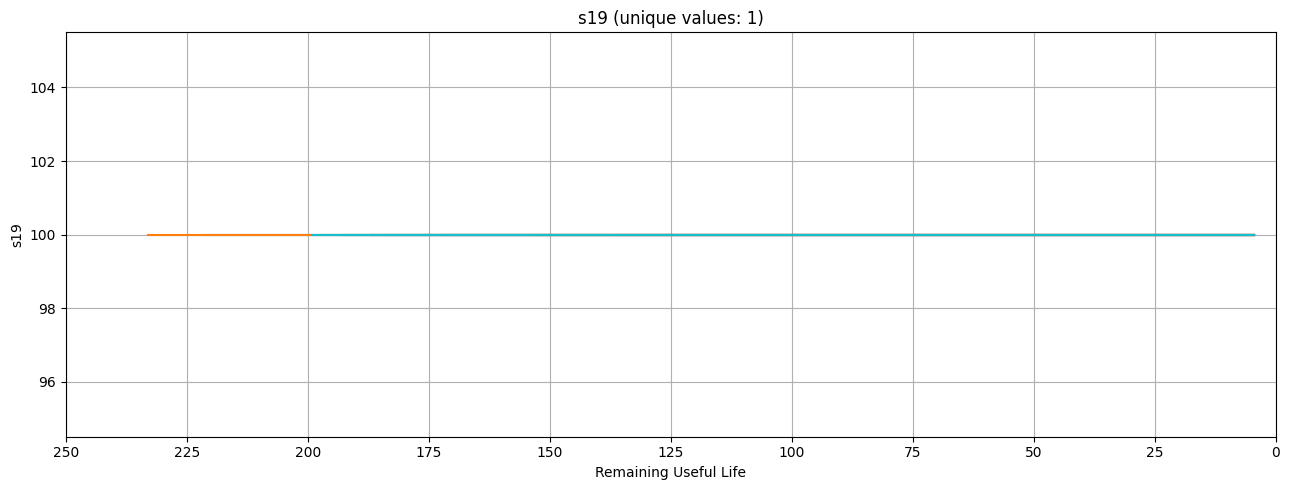

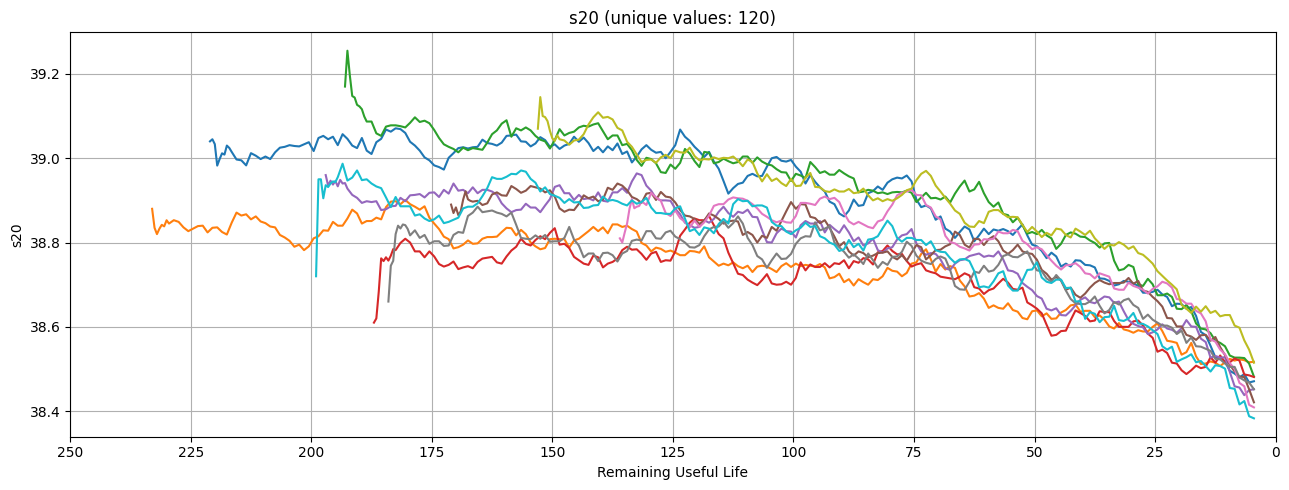

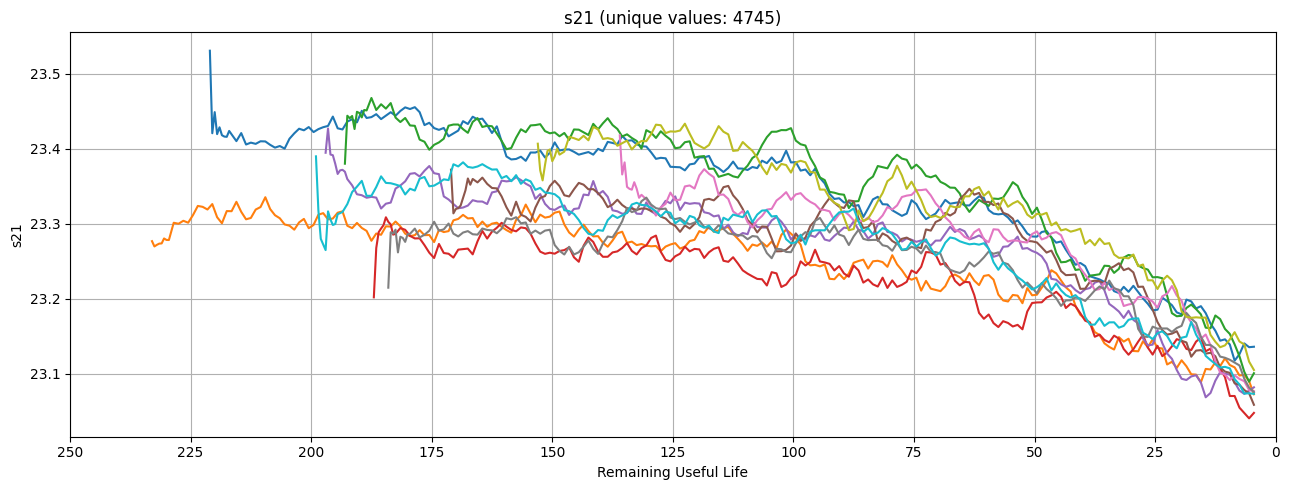

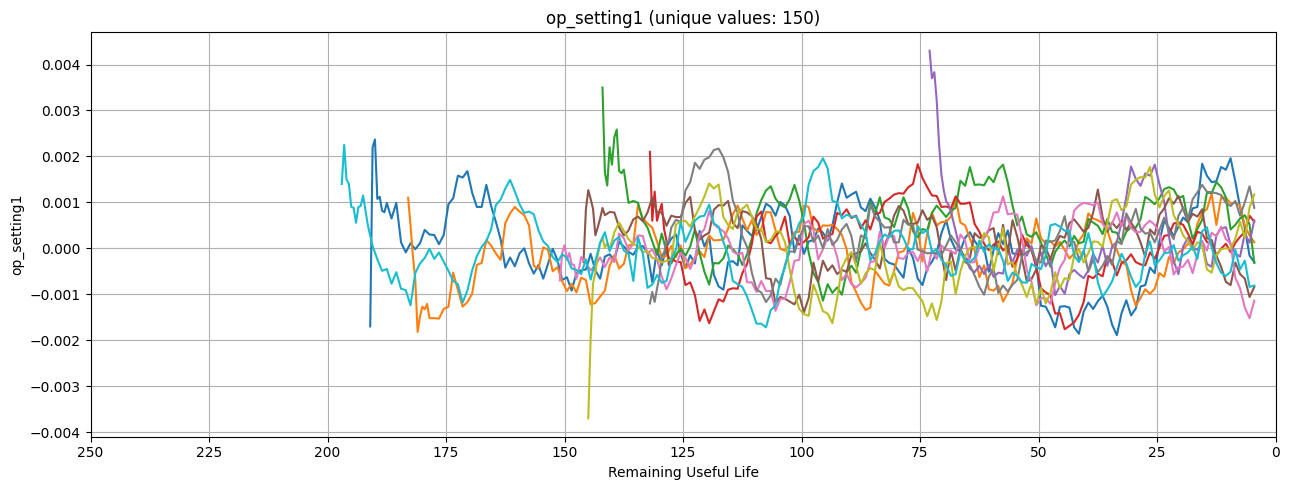

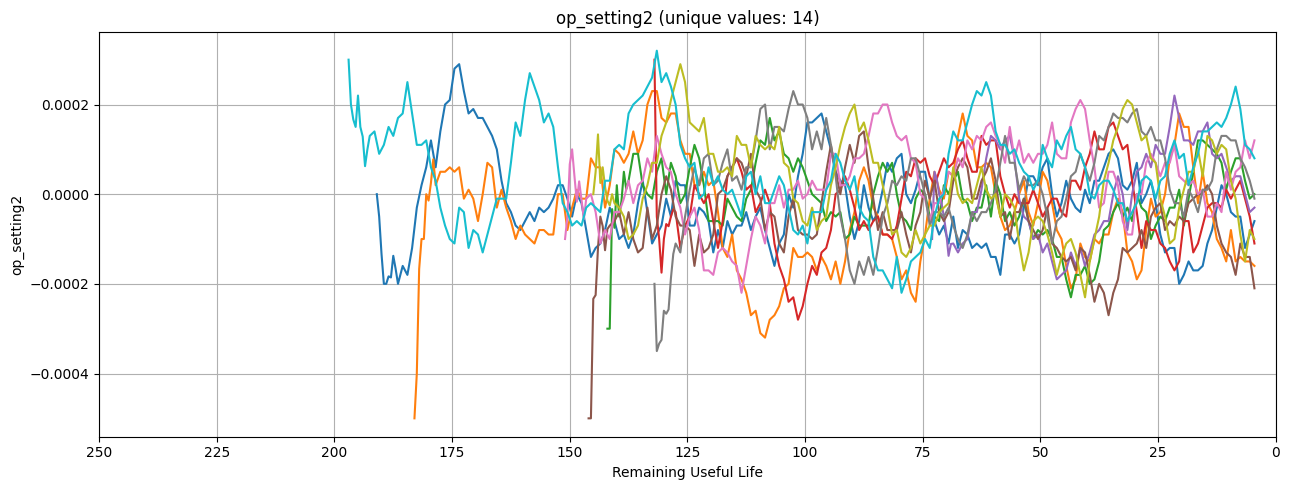

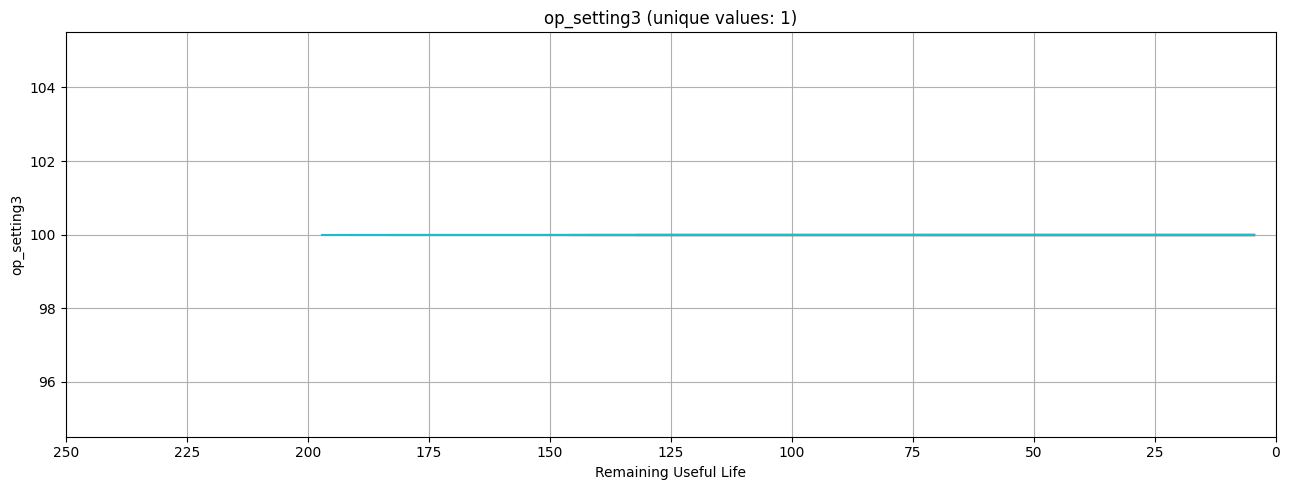

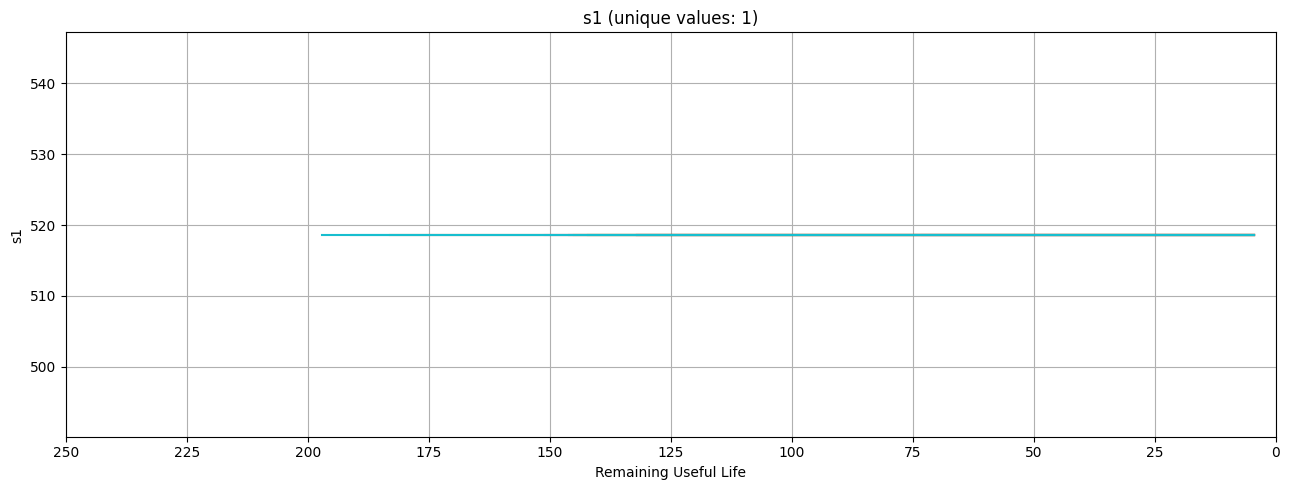

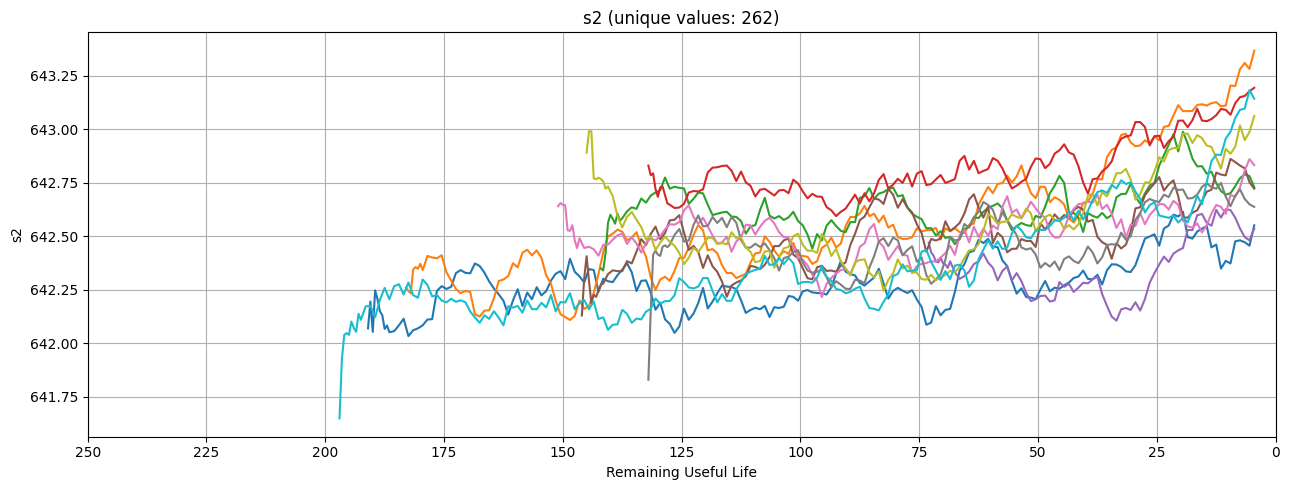

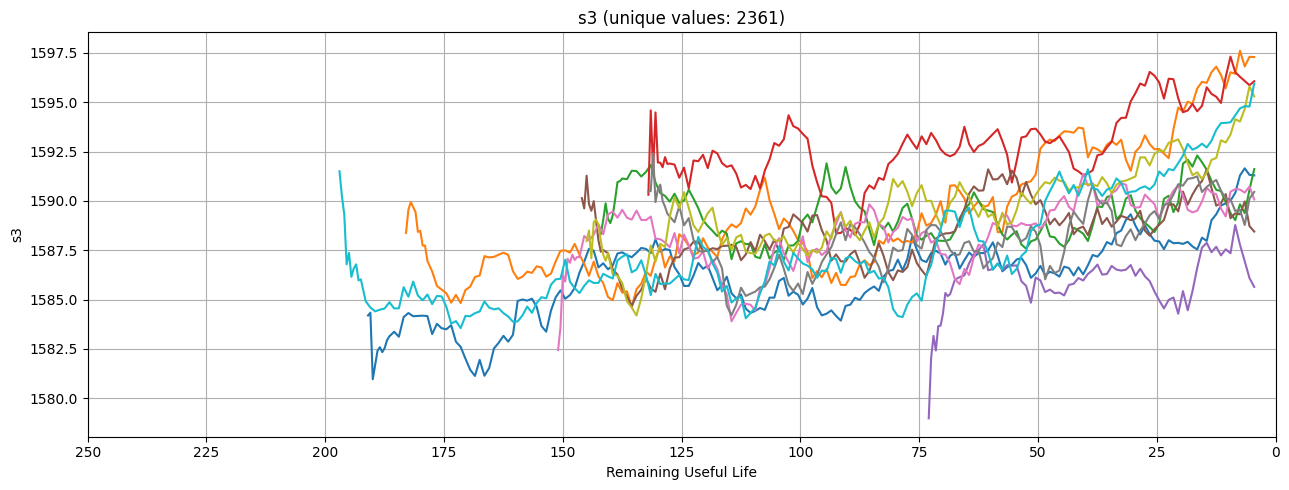

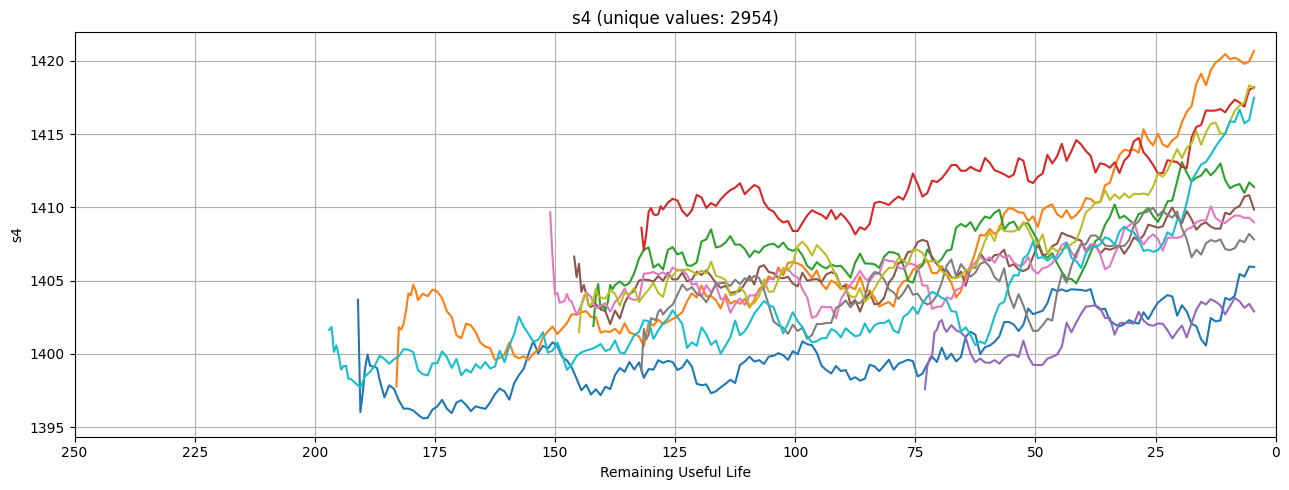

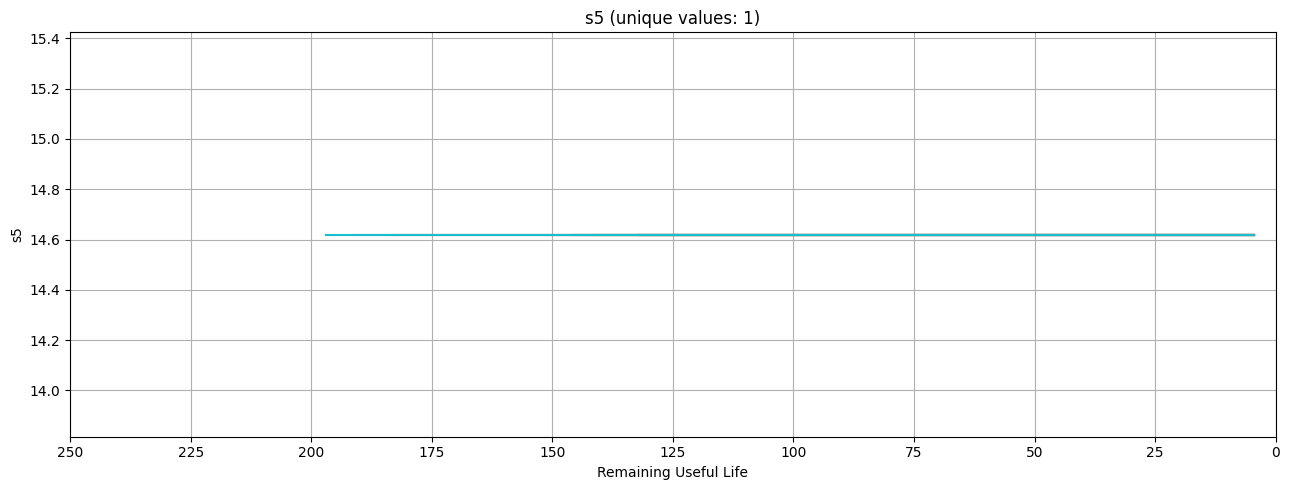

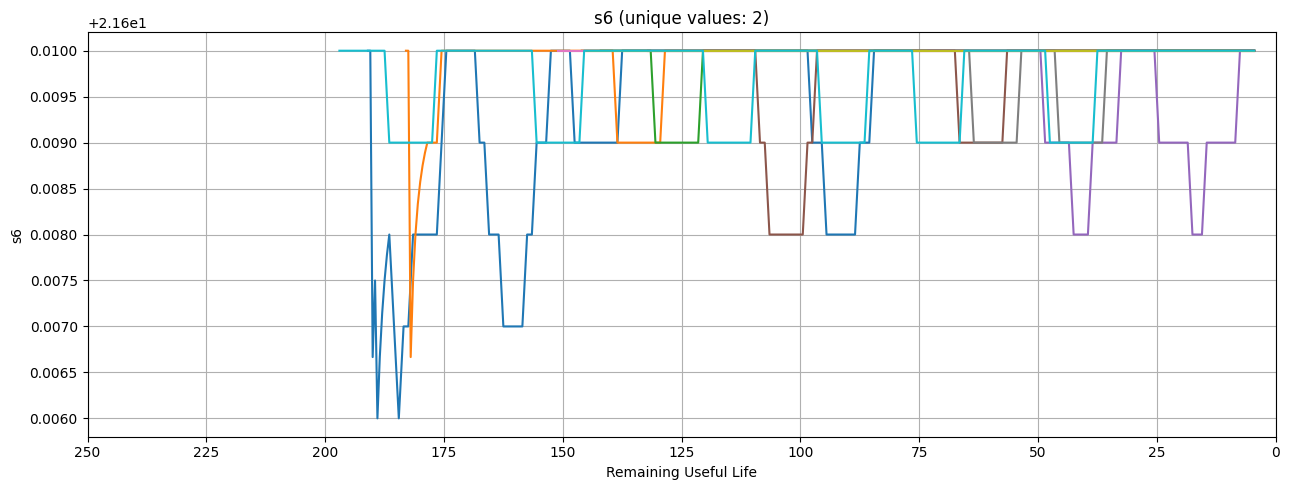

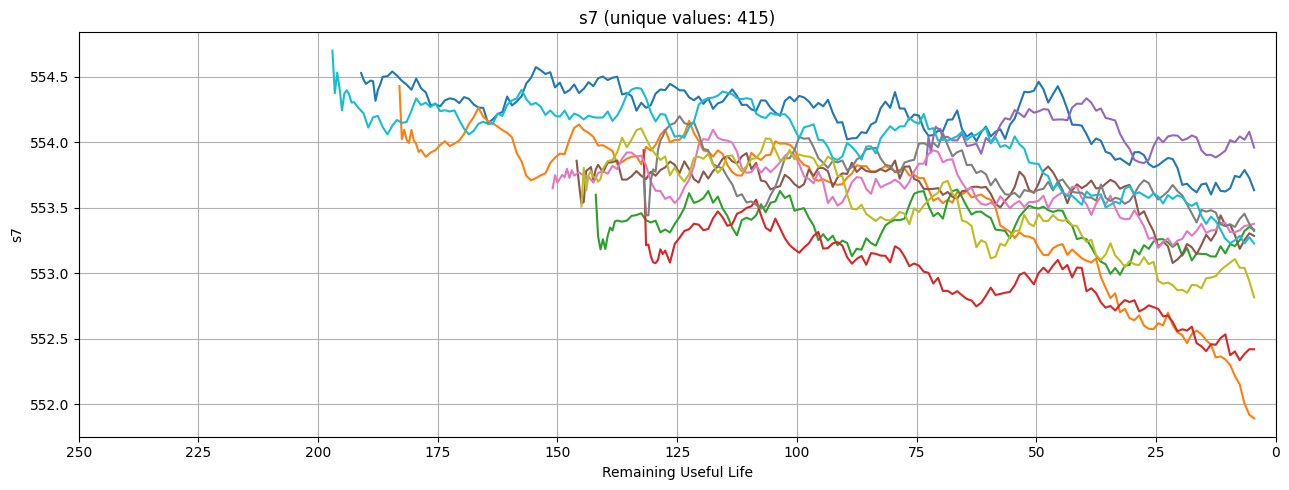

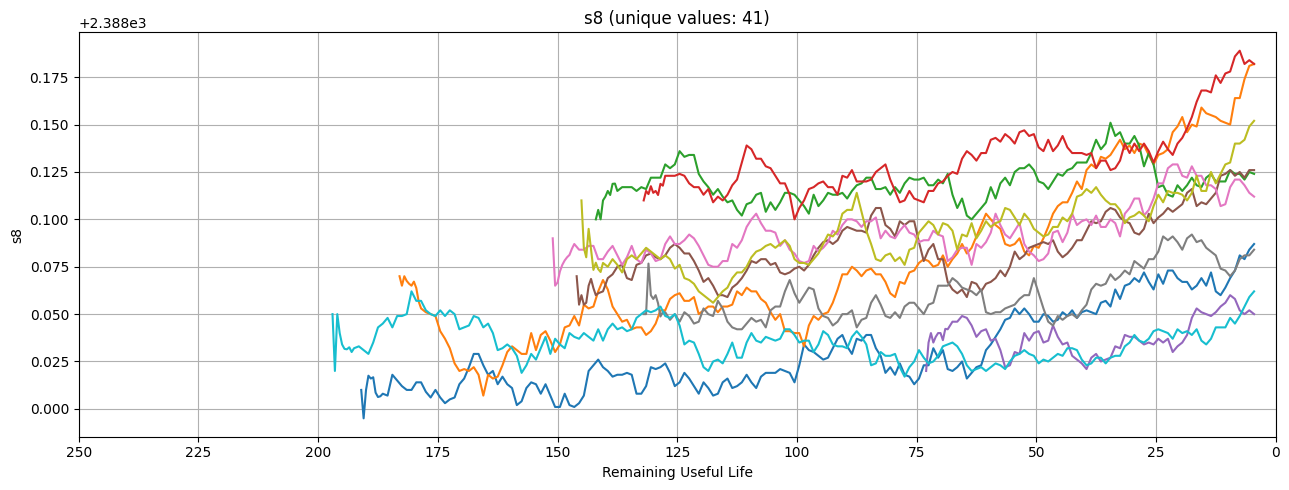

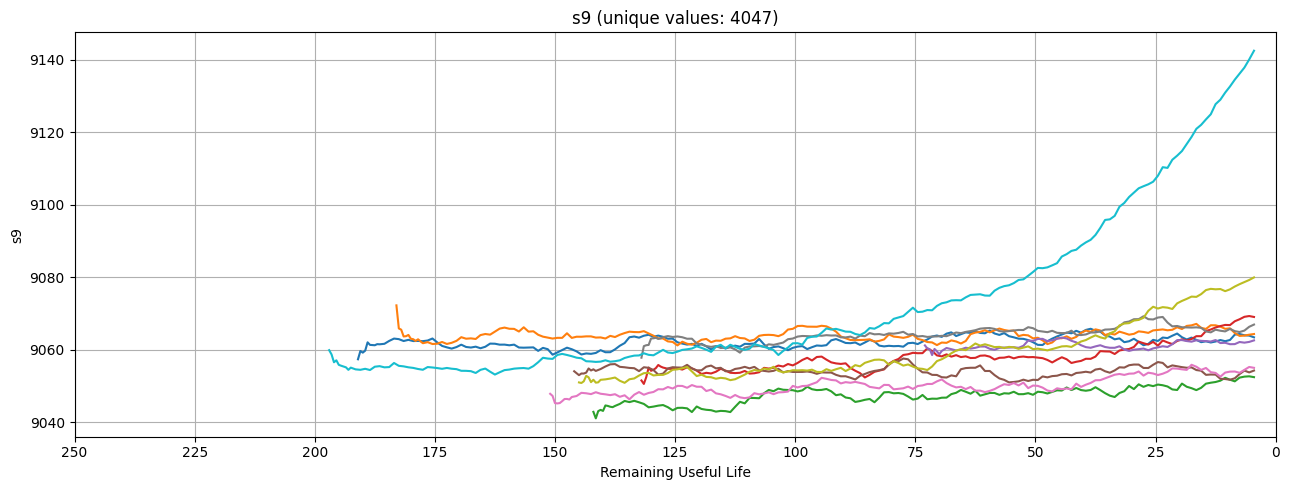

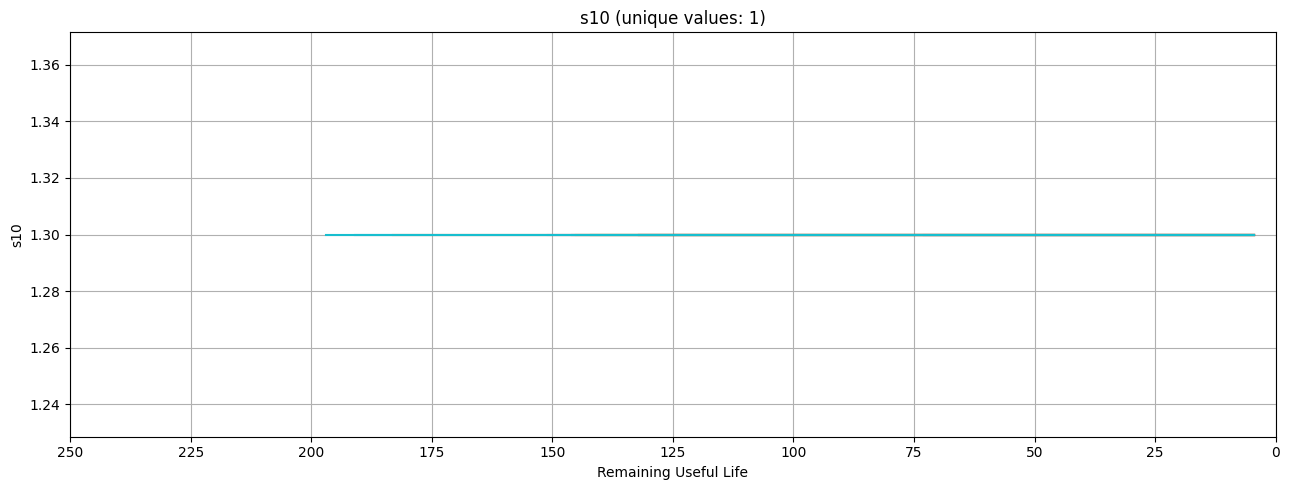

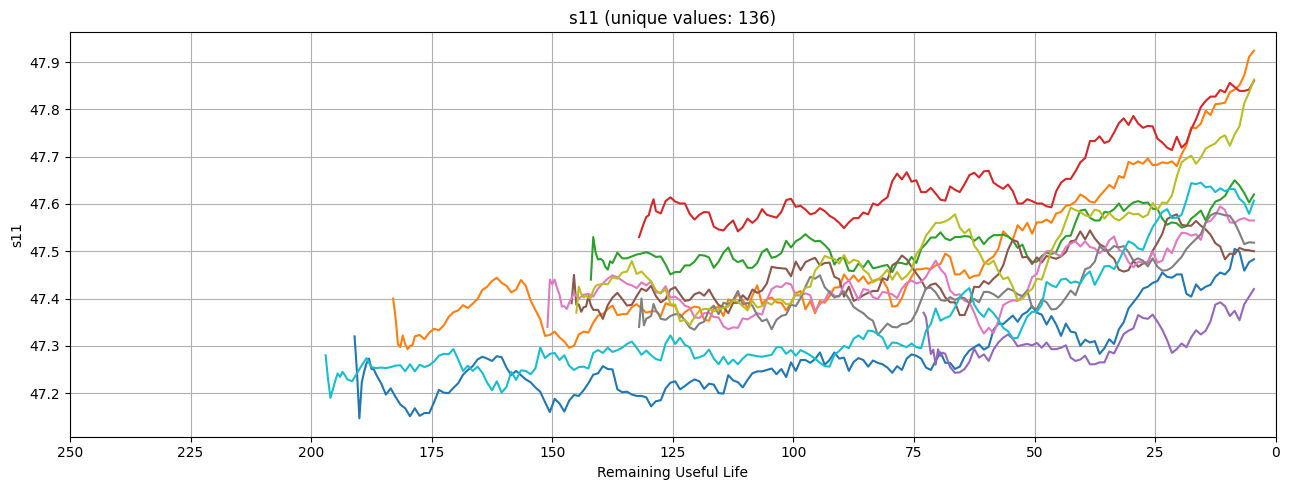

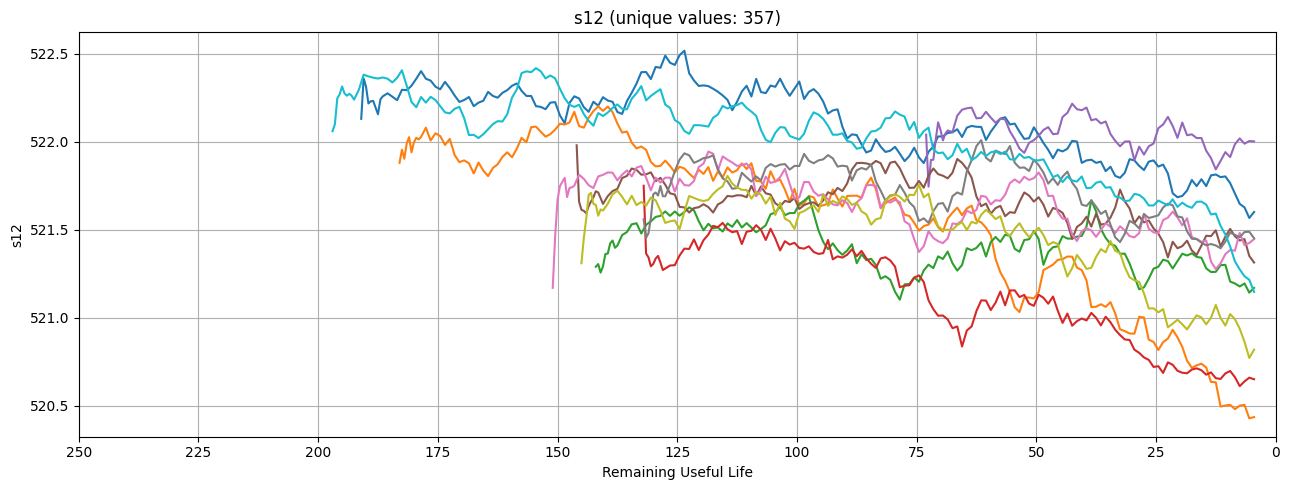

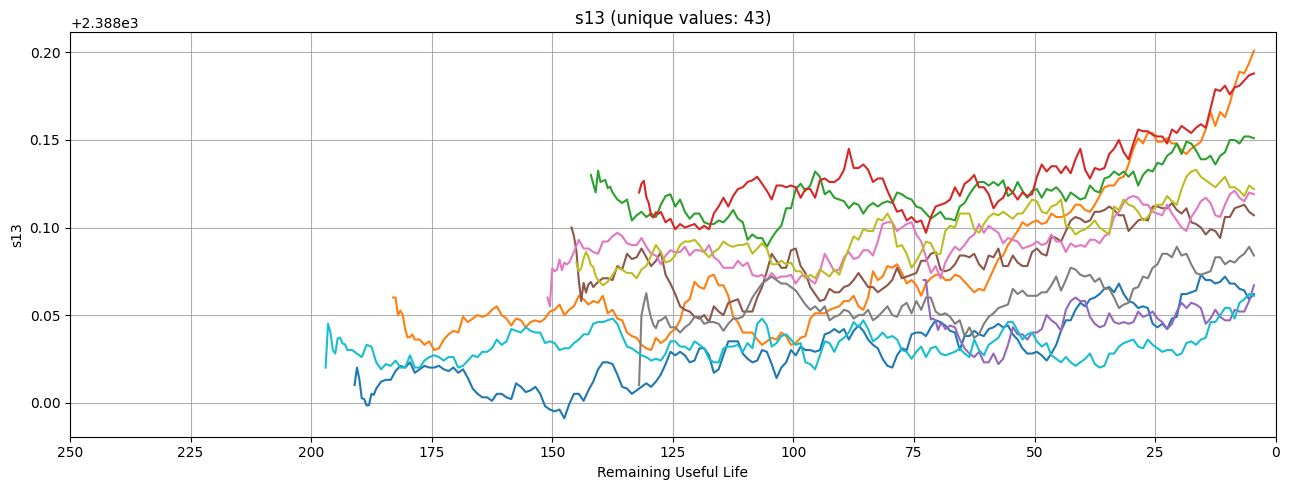

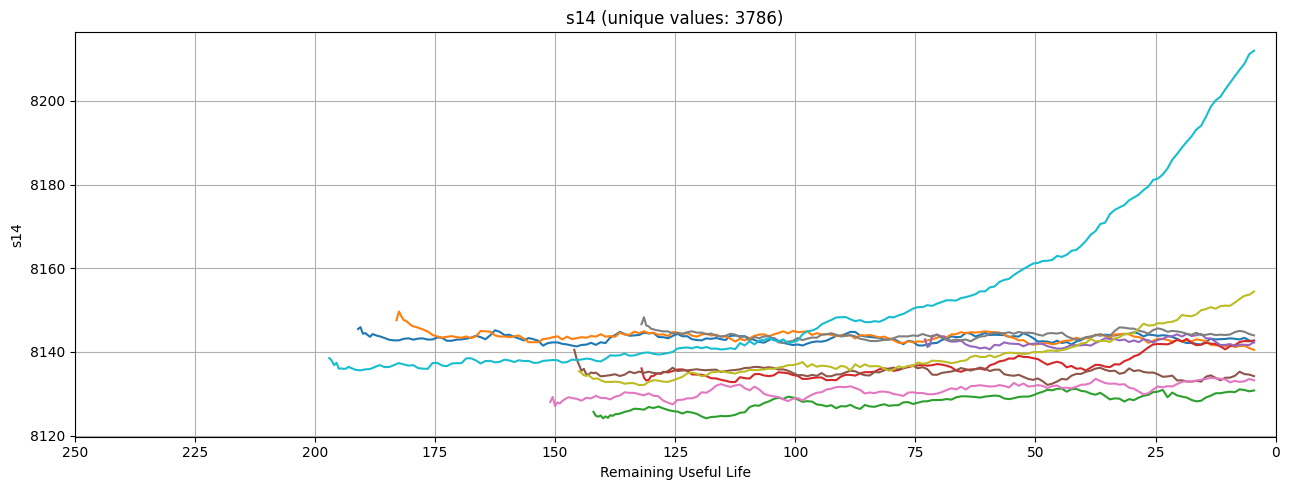

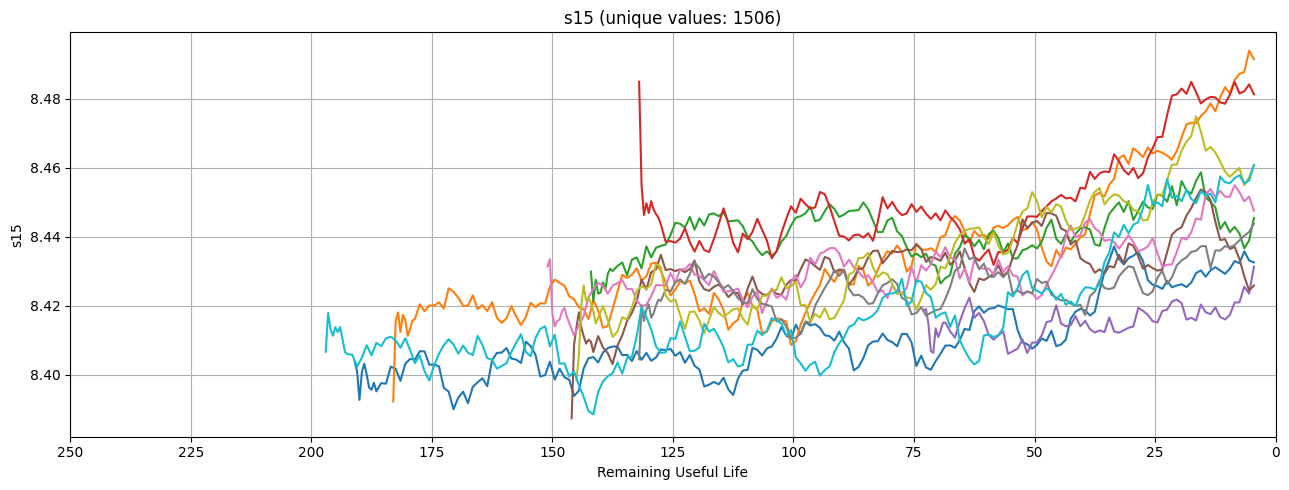

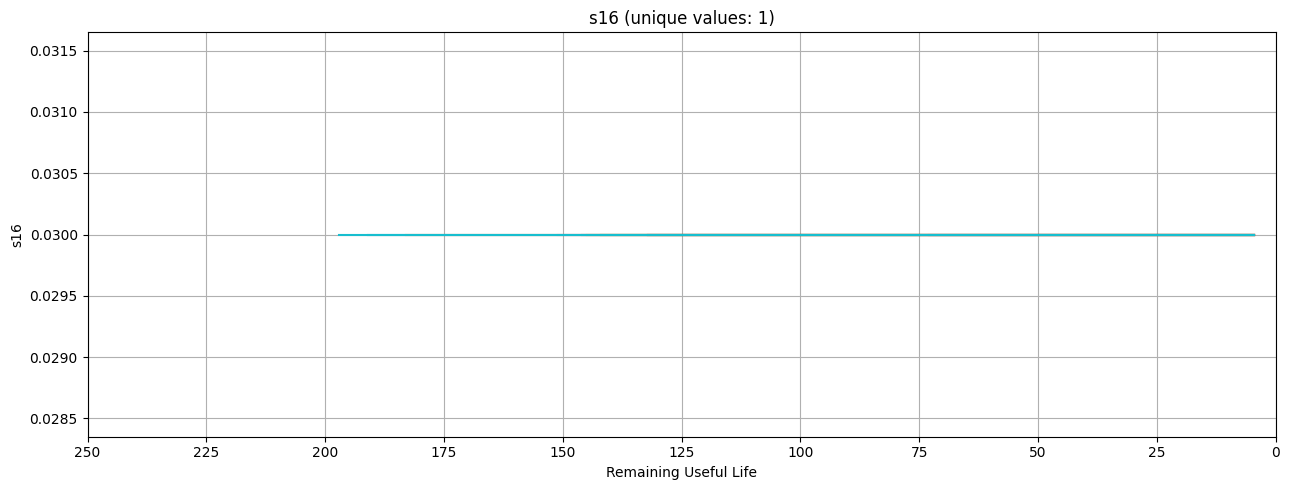

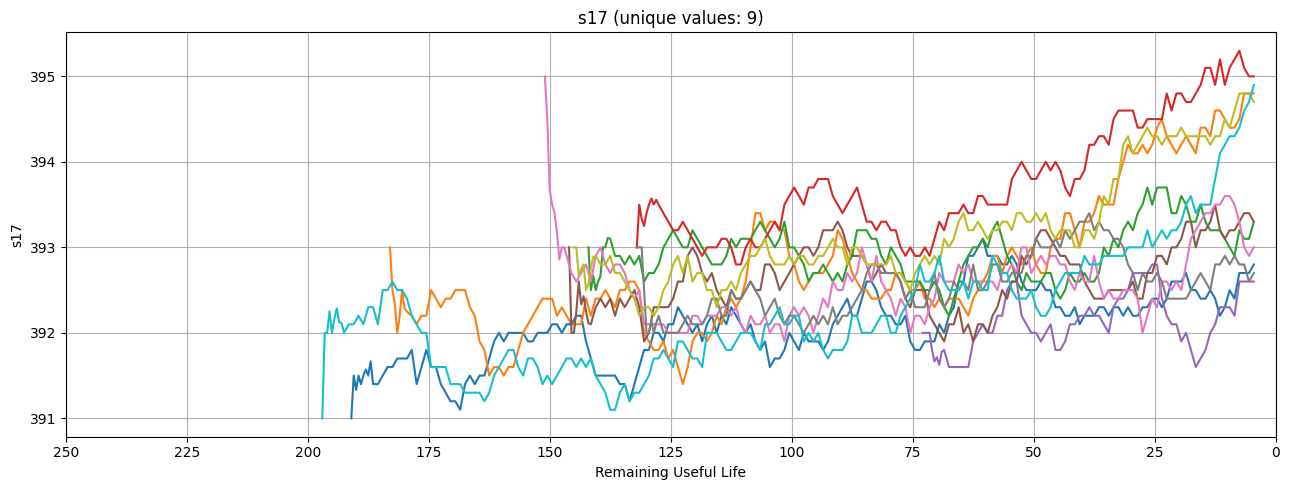

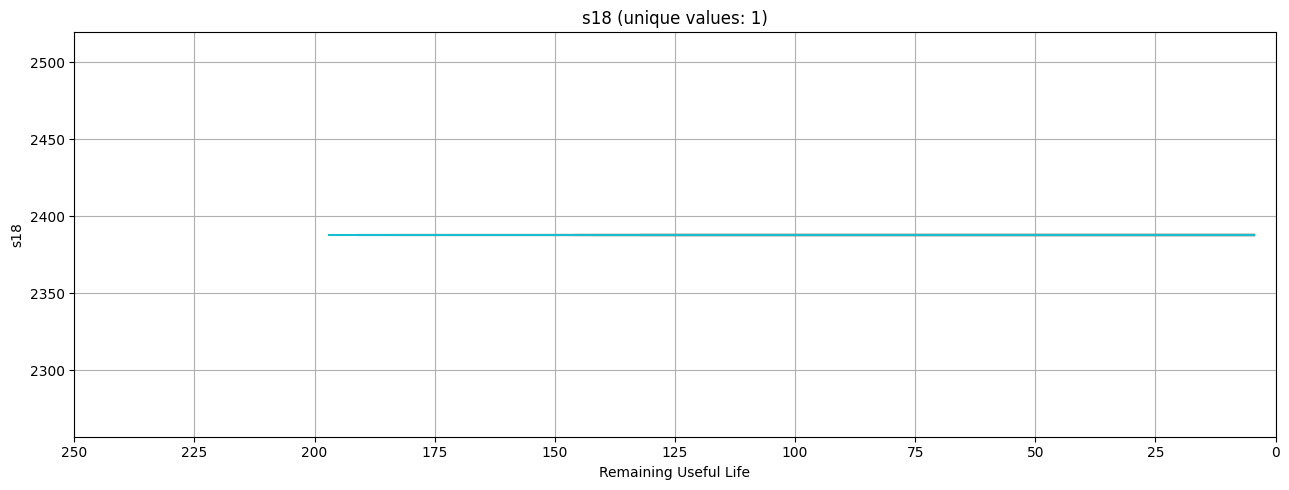

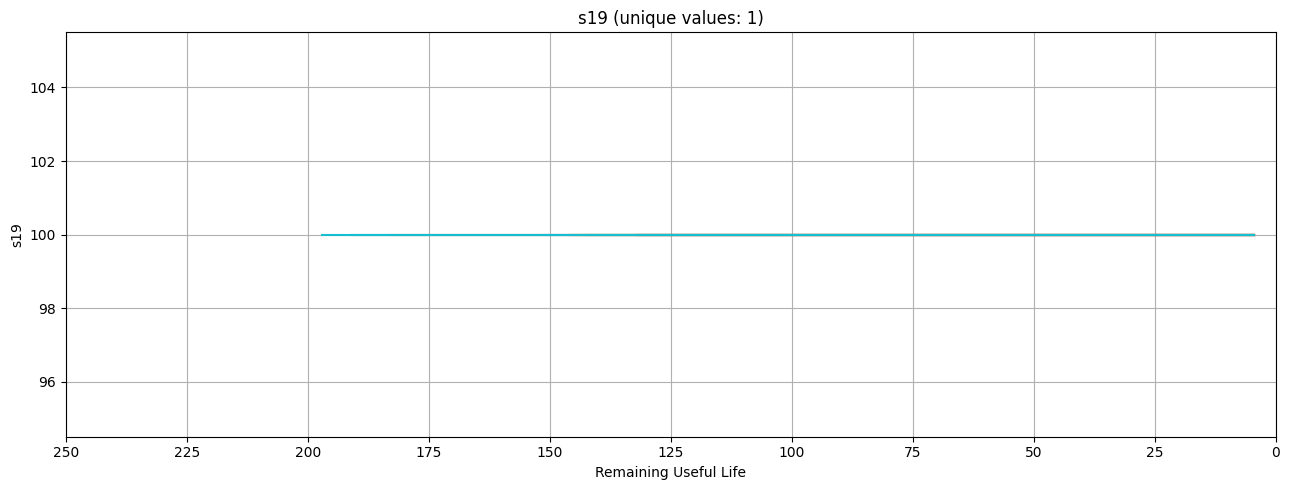

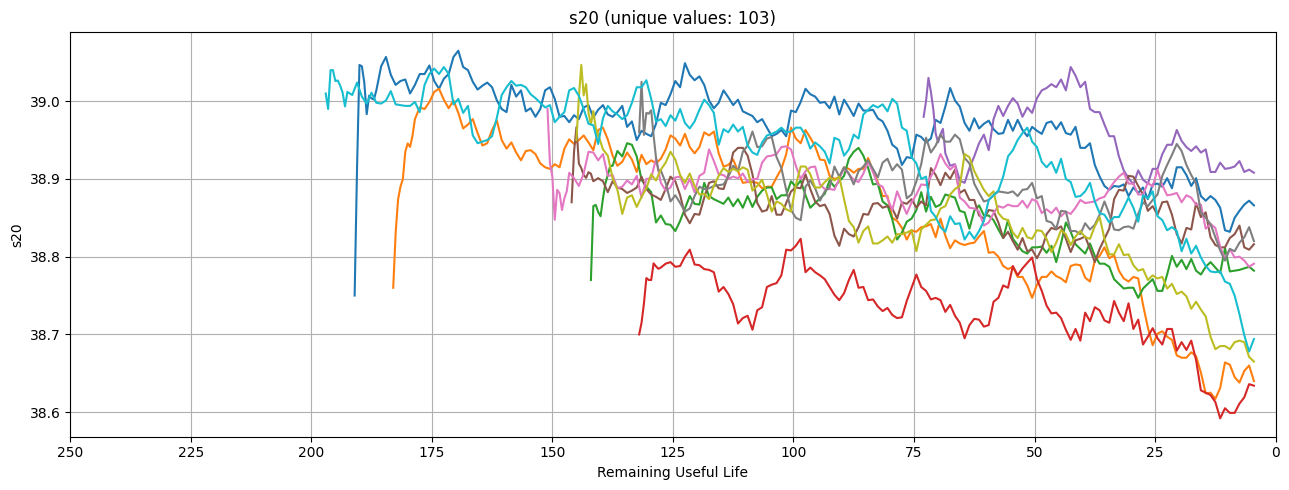

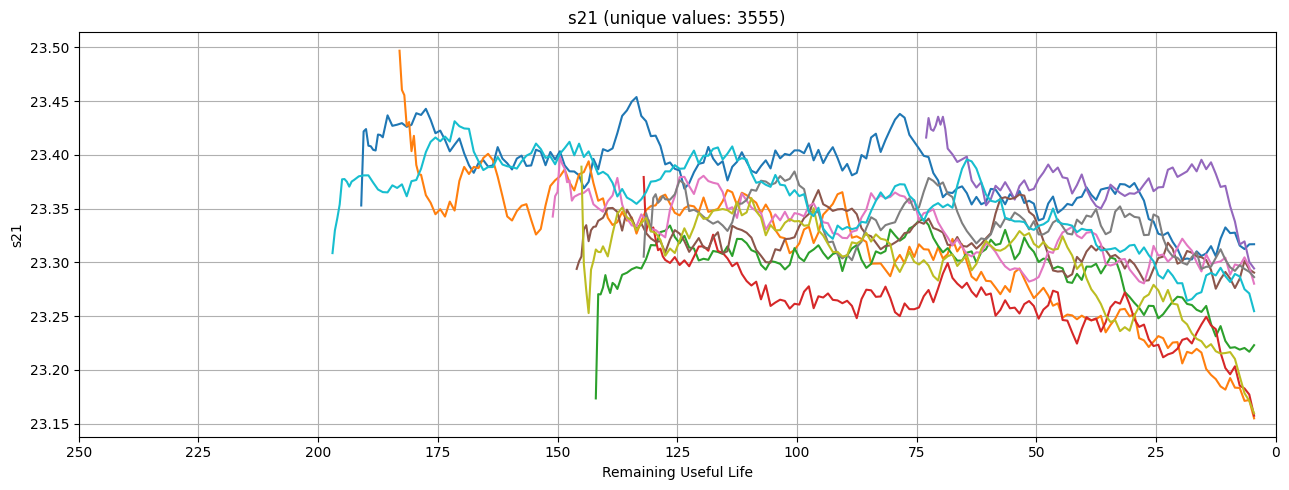

In [21]:
# 1) Add per-row RUL to TRAIN (train ends at failure, so this is true per-row RUL)
train_plot = train.copy()
train_plot["RUL"] = train_plot.groupby("unit")["cycles"].transform("max") - train_plot["cycles"]

# Optional: do the same for TEST, but this is only "cycles remaining until the file ends" (not true RUL)
test_plot = test.copy()
test_plot["RUL"] = test_plot.groupby("unit")["cycles"].transform("max") - test_plot["cycles"]

# 2) A simple label dictionary (since s1..s21 have no human names here)
Sensor_dictionary = {c: c for c in train_plot.columns}

def plot_signal(df, Sensor_dic, signal_name, unit_col="unit", roll_window=10, every_n_units=10, max_rul=250):
    plt.figure(figsize=(13, 5))

    for u in sorted(df[unit_col].unique()):
        if u % every_n_units == 0:  # plot only every 10th unit for readability
            d = df[df[unit_col] == u].sort_values("cycles")
            d_roll = d.rolling(roll_window, min_periods=1).mean(numeric_only=True)
            plt.plot(d_roll["RUL"], d_roll[signal_name])

    # reverse the x-axis so RUL counts down to zero
    # if your max RUL is bigger than max_rul, increase max_rul (e.g., 400)
    plt.xlim(max_rul, 0)
    plt.xticks(np.arange(0, max_rul + 1, 25))

    plt.ylabel(Sensor_dic.get(signal_name, signal_name))
    plt.xlabel("Remaining Useful Life")
    plt.title(f"{signal_name} (unique values: {df[signal_name].nunique()})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3) Plot op settings + all sensors (1..21)
cols_to_plot = ["op_setting1", "op_setting2", "op_setting3"] + [f"s{i}" for i in range(1, 22)]

# TRAIN plots (true per-row RUL)
for col in cols_to_plot:
    try:
        plot_signal(train_plot, Sensor_dictionary, col, max_rul=250)
    except Exception:
        pass

# TEST plots (optional, uses "time remaining in file" instead of true RUL)
for col in cols_to_plot:
    try:
        plot_signal(test_plot, Sensor_dictionary, col, max_rul=250)
    except Exception:
        pass


In this dataset, the flat sensors are:

`s1, s5, s10, s16, s18, s19`, and also `op_setting3`.

Since those columns provide no variation, they provide no learning signal. So I remove them from both train and test.

In [22]:
train.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)
test.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)

Now I look at the feature distributions to understand scale differences across sensors. Some sensors live in tight ranges, others swing more widely, and this later motivates scaling.

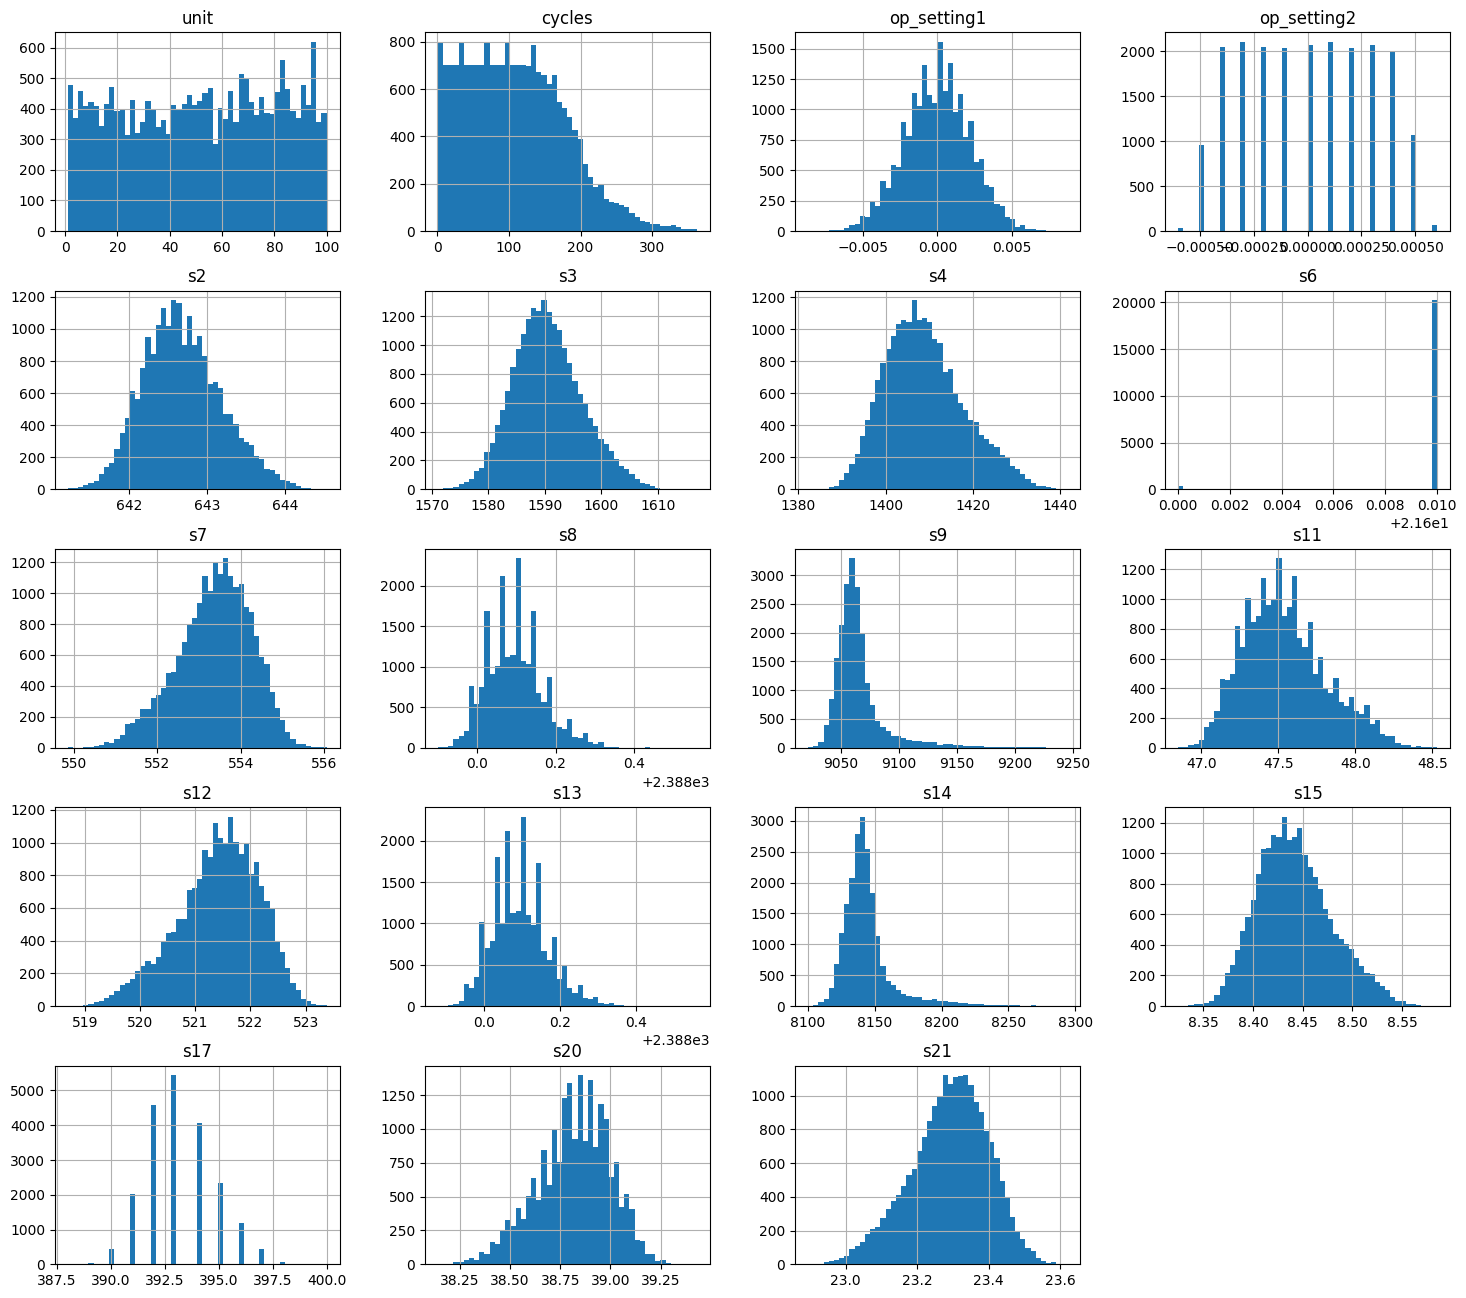

In [23]:
train.hist(bins=50, figsize=(18,16))
plt.show()

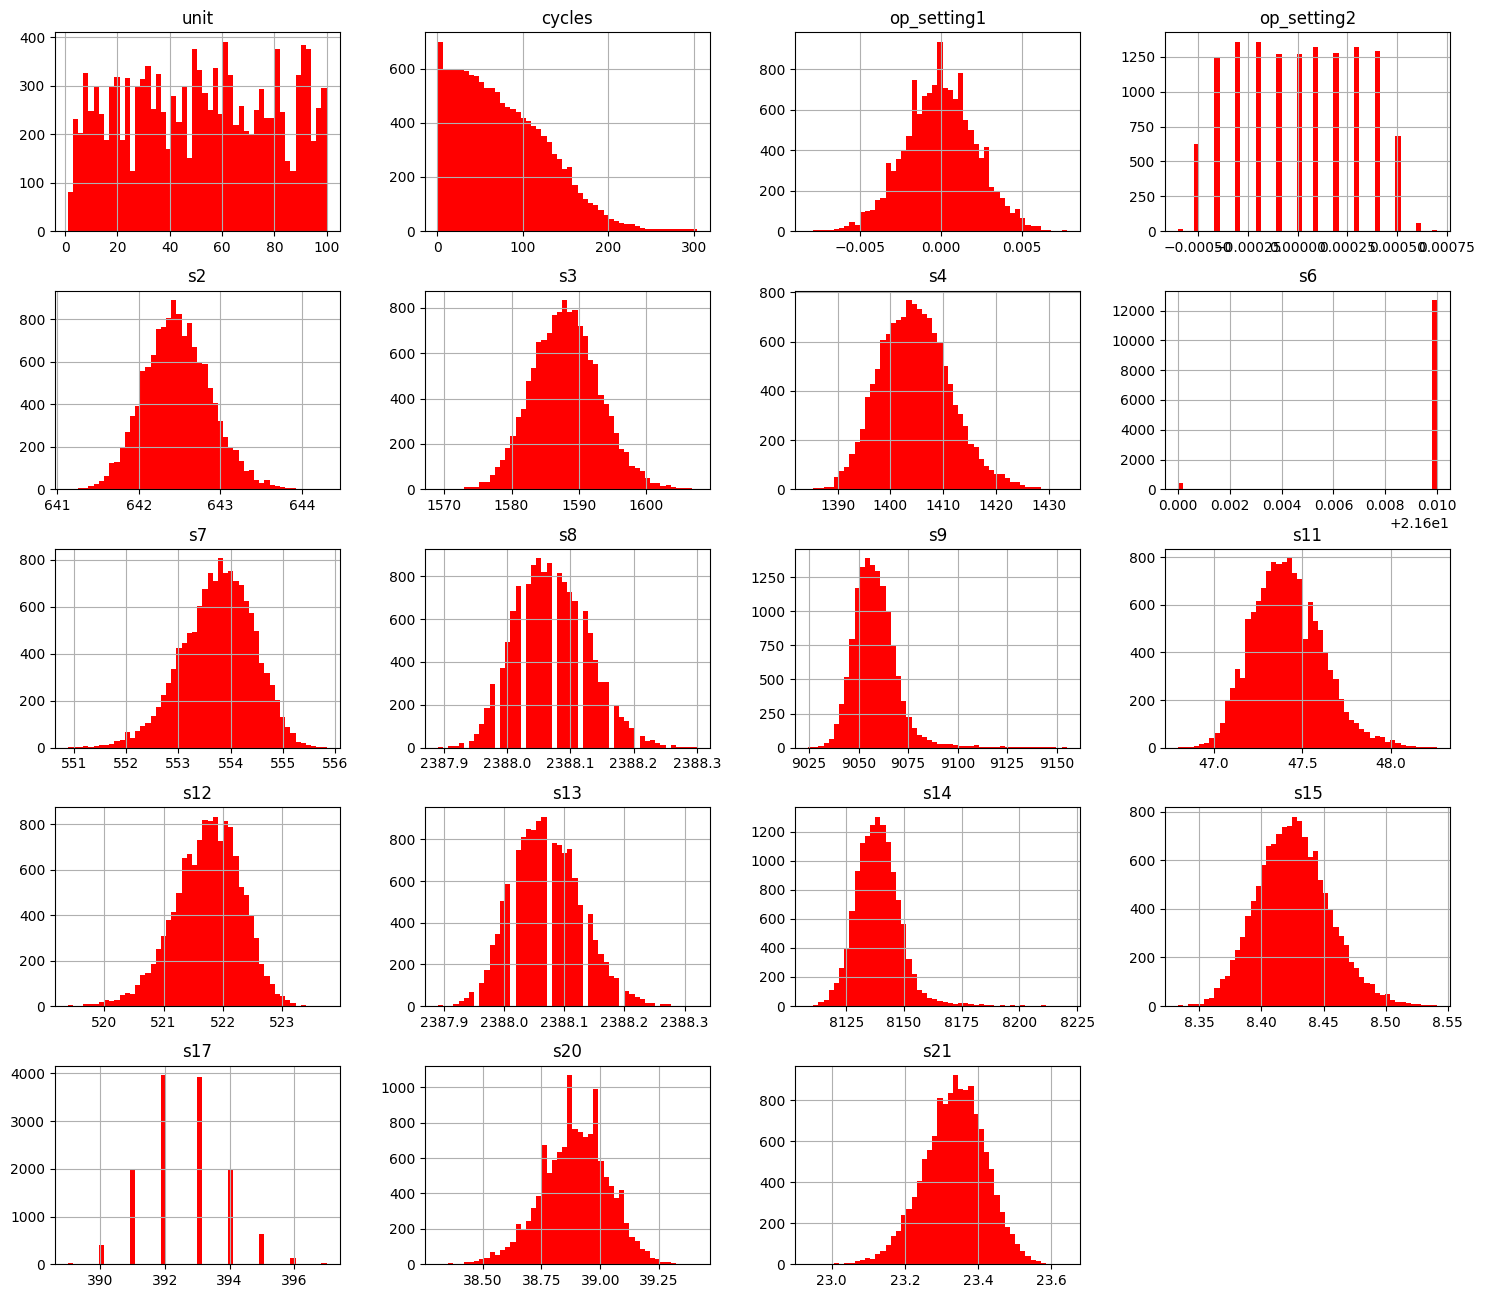

In [24]:
test.hist(bins=50, figsize=(18,16), color="red")
plt.show()

## Exploratory Analysis of Maximum Cycles per Unit

Now I want to understand how long engines survive in the training data. Each unit has a different lifetime, so I compute the maximum cycle per unit.
Then I plot the results. The training set should show full lifetimes. The test set should show shorter sequences because the recording stops early.

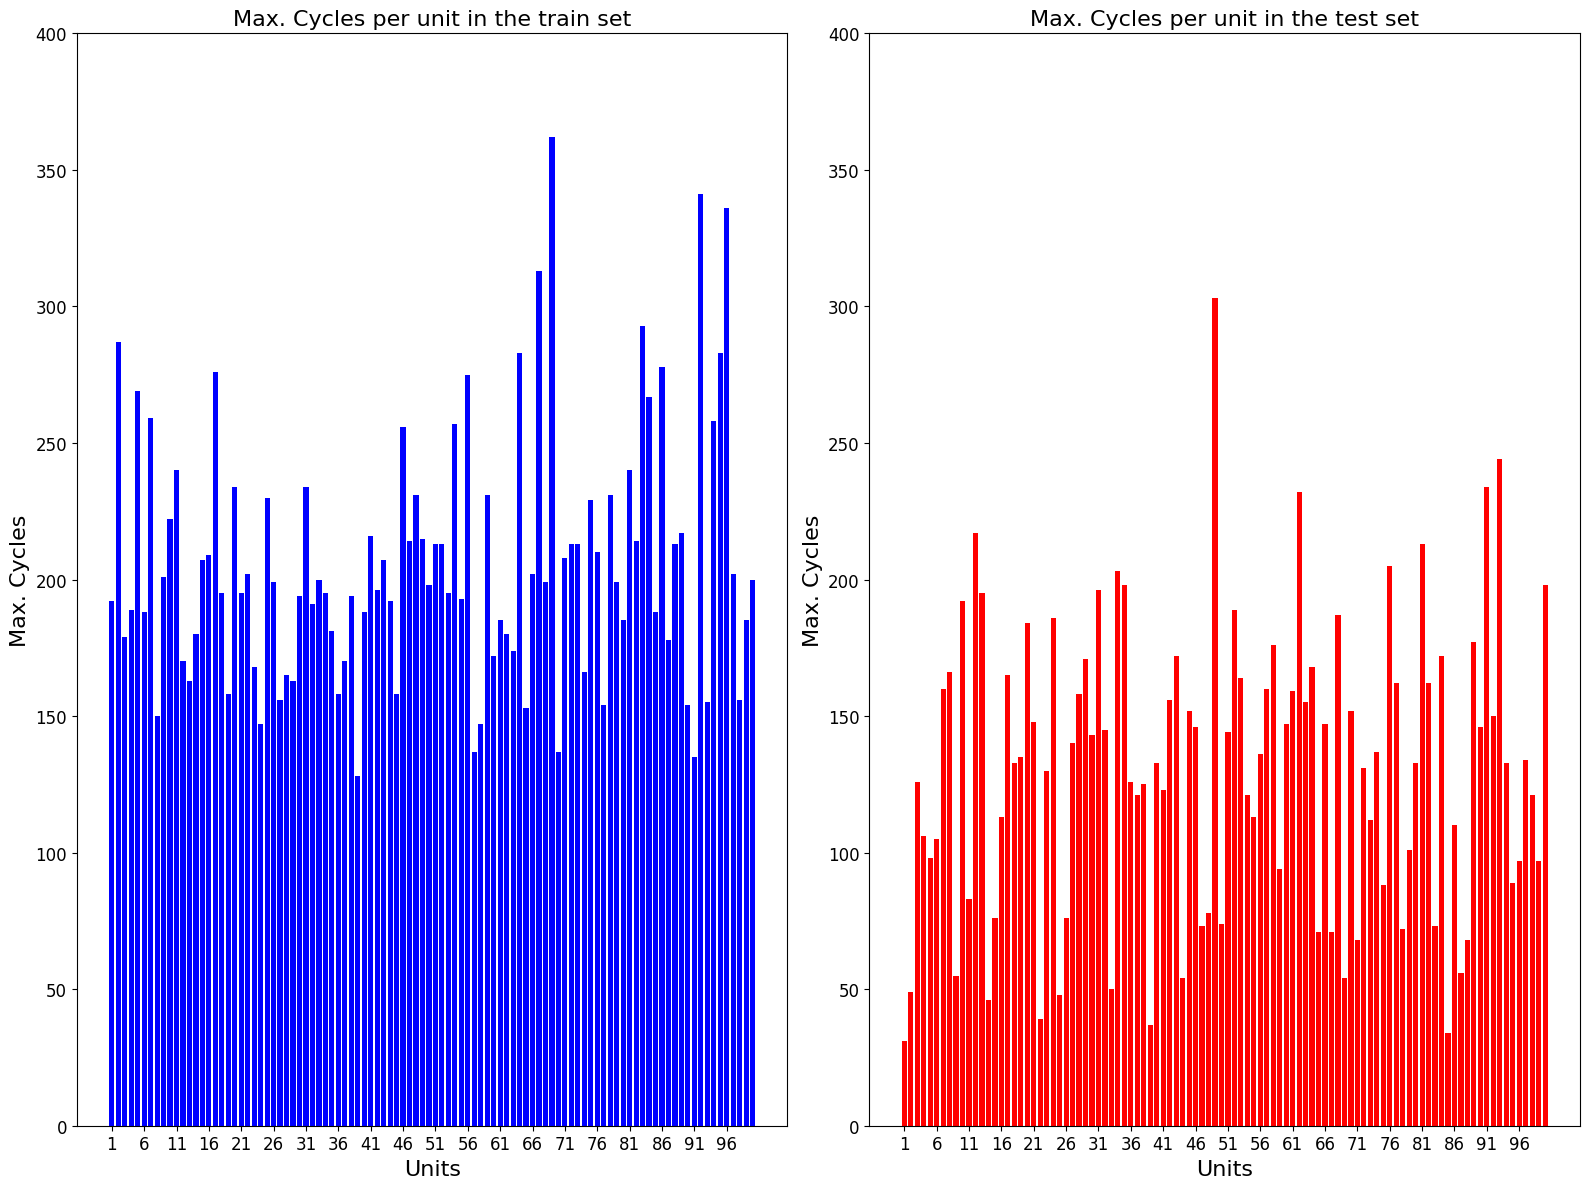

In [25]:
cyclestrain = train.groupby('unit', as_index=False)['cycles'].max()
cyclestest  = test.groupby('unit', as_index=False)['cycles'].max()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))

# Train plot
ax1.bar(cyclestrain['unit'], cyclestrain['cycles'], color='blue')
ax1.set_ylim(0, 400)
ax1.set_xlabel('Units', fontsize=16)
ax1.set_ylabel('Max. Cycles', fontsize=16)
ax1.set_title('Max. Cycles per unit in the train set', fontsize=16)
ax1.set_xticks(np.arange(cyclestrain['unit'].min(), cyclestrain['unit'].max() + 1, 5))
ax1.tick_params(axis='both', labelsize=12)

# Test plot
ax2.bar(cyclestest['unit'], cyclestest['cycles'], color='red')
ax2.set_ylim(0, 400)
ax2.set_xlabel('Units', fontsize=16)
ax2.set_ylabel('Max. Cycles', fontsize=16)
ax2.set_title('Max. Cycles per unit in the test set', fontsize=16)
ax2.set_xticks(np.arange(cyclestest['unit'].min(), cyclestest['unit'].max() + 1, 5))
ax2.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

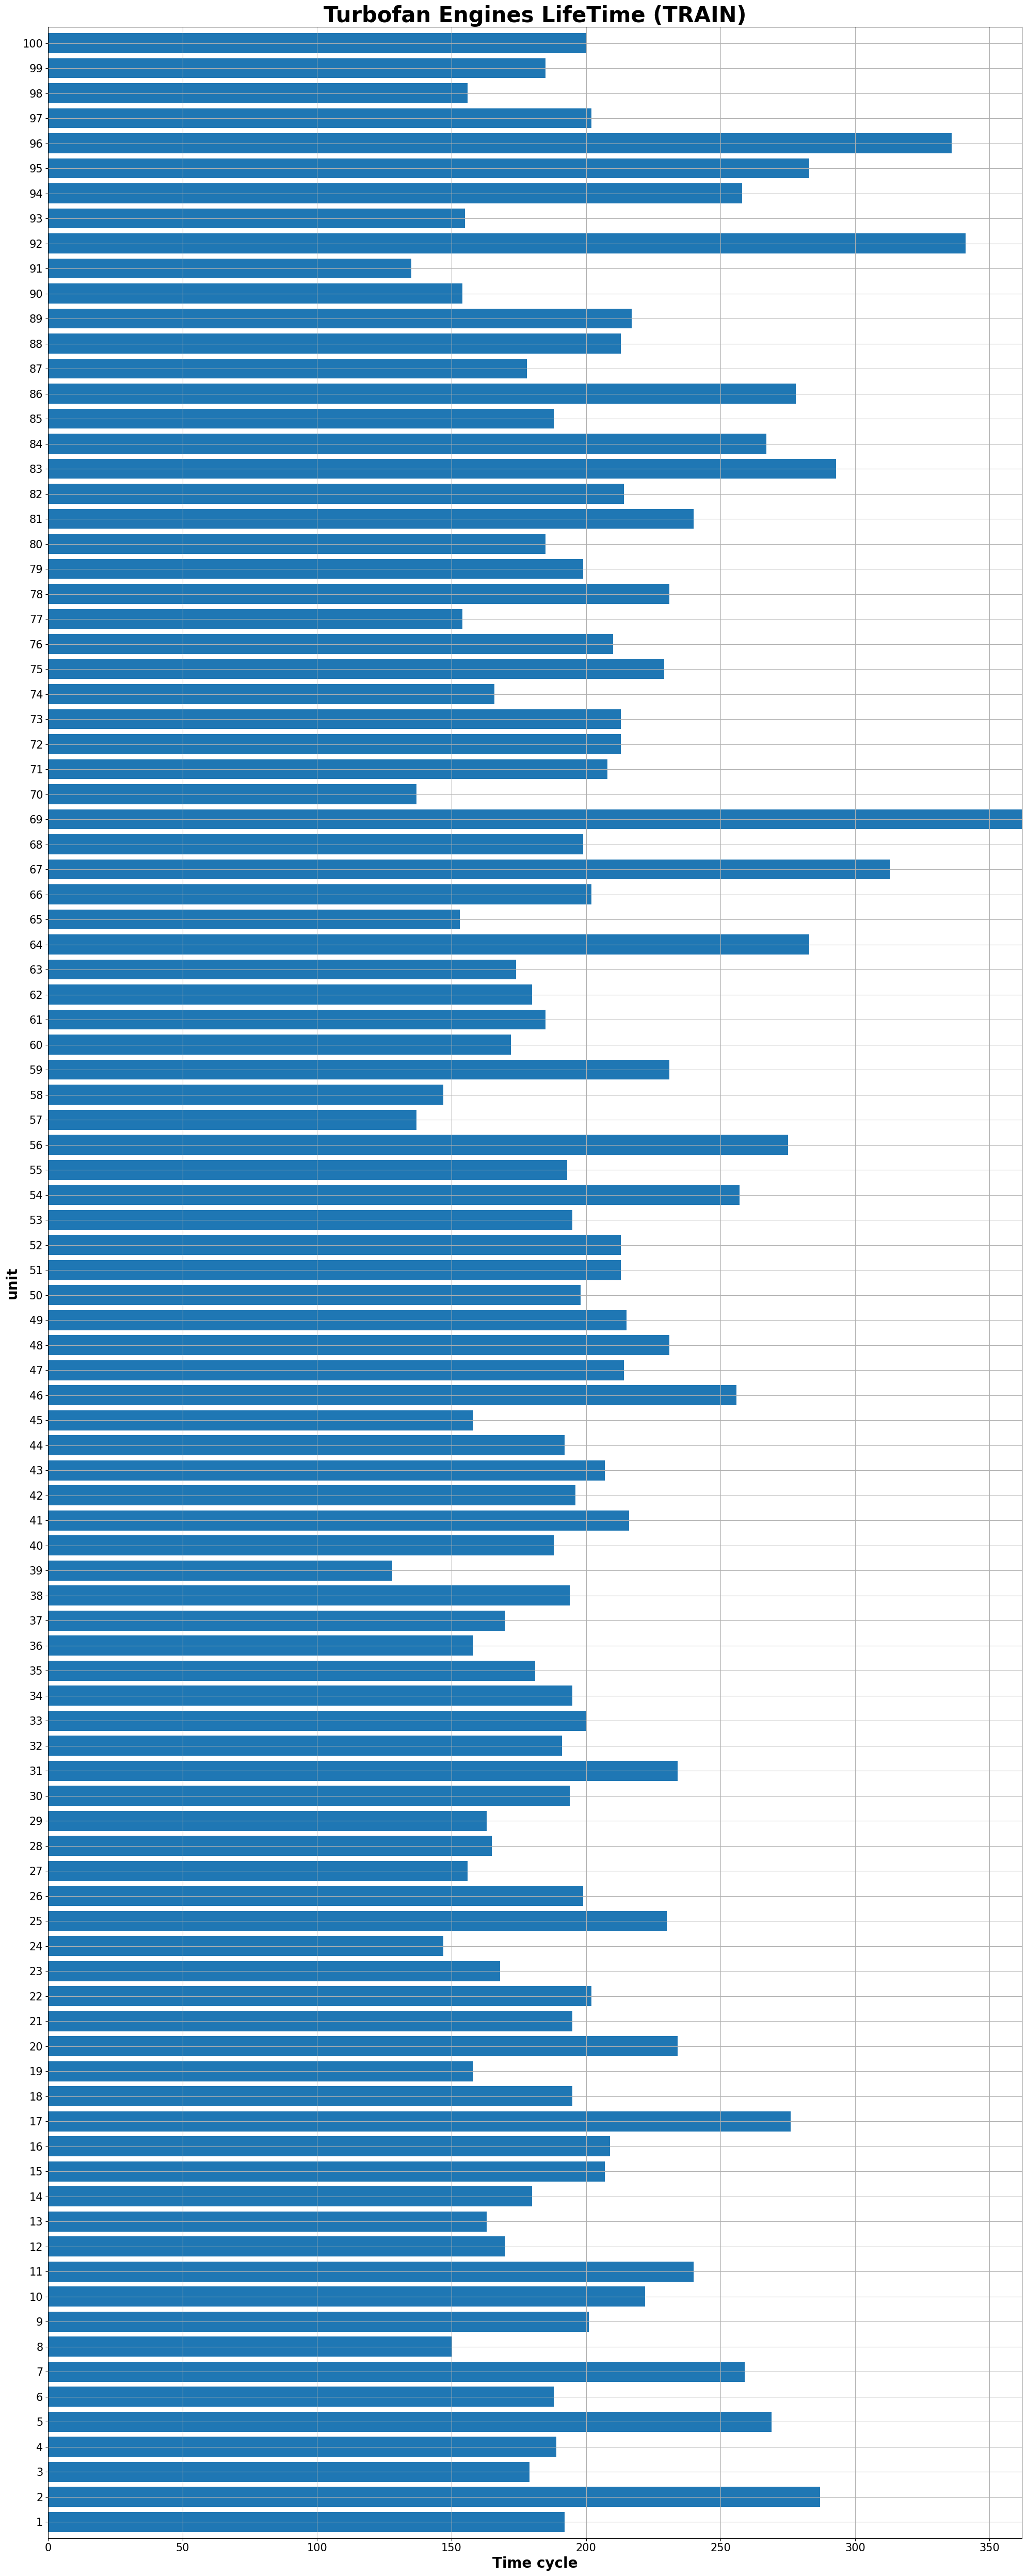

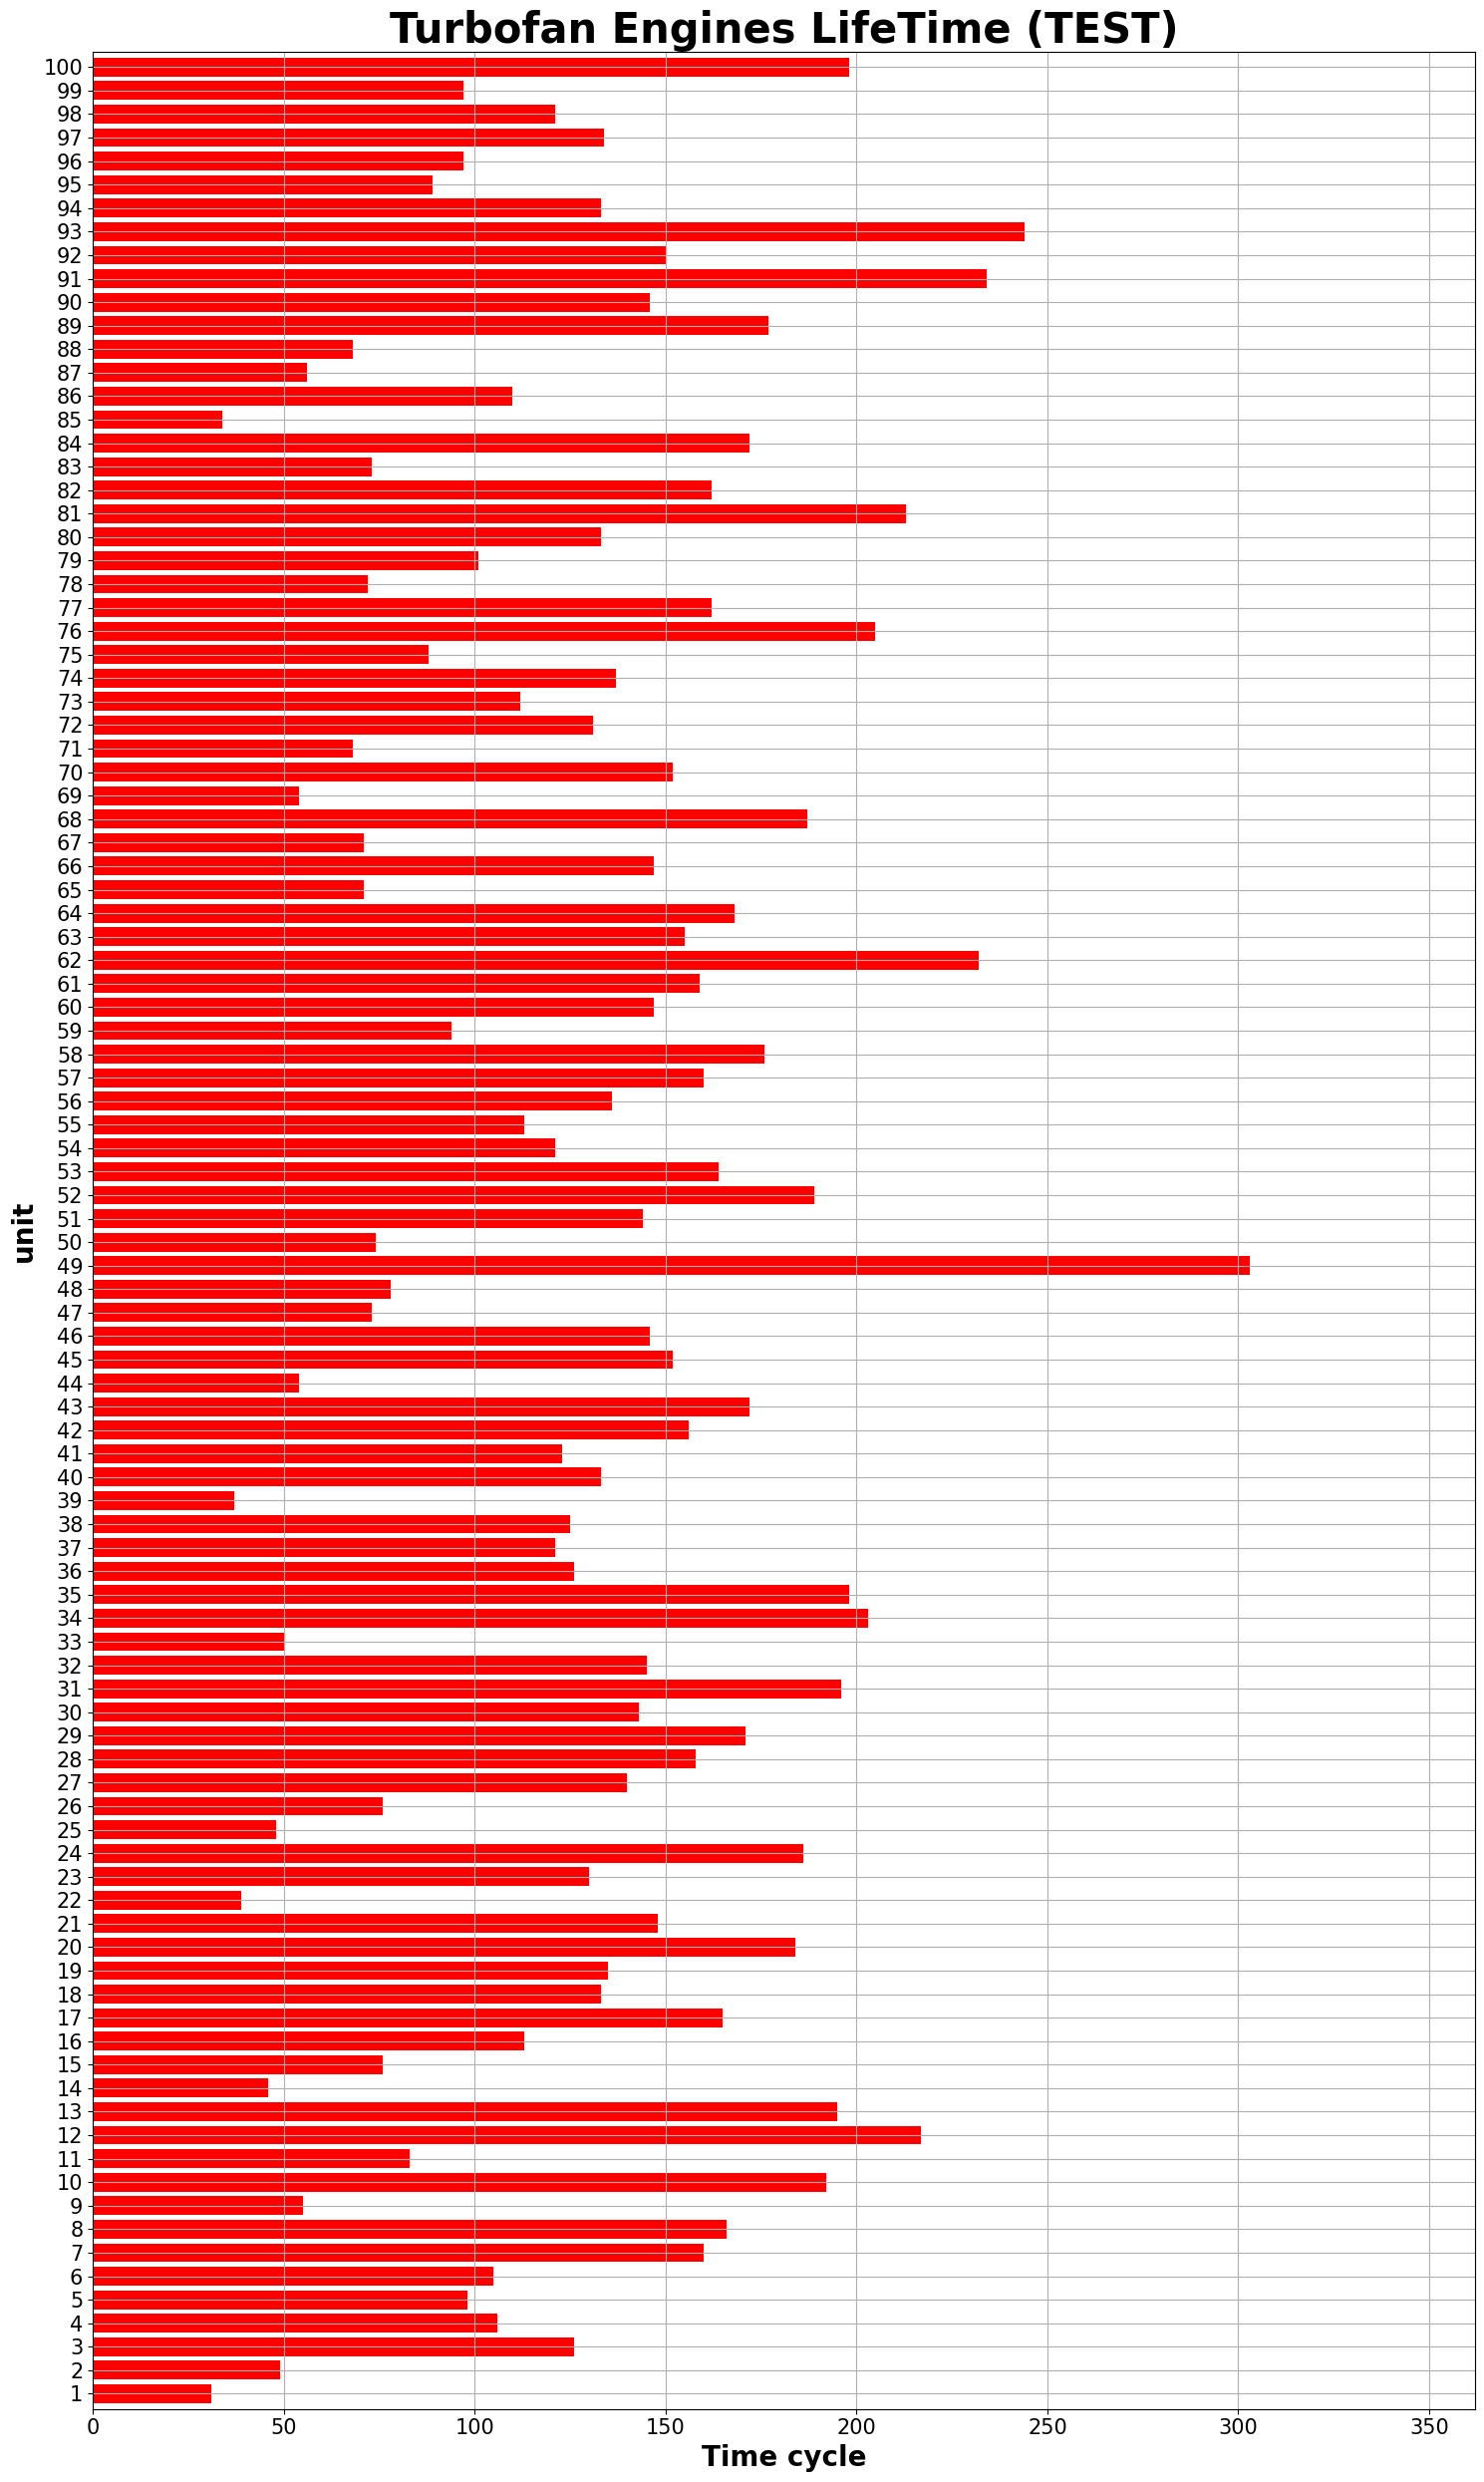

In [26]:
def plot_engine_lifetimes(
    df,
    title,
    unit_col="unit",
    cycle_col="cycles",
    color=None,
    figsize=(20, 50),
    xlim=None
):
    # max observed cycle per unit (lifetime inside this file)
    max_cycles = df.groupby(unit_col)[cycle_col].max()

    # order by unit number (index), not by lifetime value
    max_cycles = max_cycles.sort_index()

    plt.figure(figsize=figsize)
    ax = max_cycles.plot(kind="barh", width=0.8, color=color)

    if xlim is not None:
        plt.xlim(xlim)

    plt.title(title, fontweight="bold", size=30)
    plt.xlabel("Time cycle", fontweight="bold", size=20)
    plt.ylabel("unit", fontweight="bold", size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Use the TRAIN max cycle as a shared x-axis limit so TEST bars look smaller (true comparison).
train_max = train.groupby("unit")["cycles"].max().max()

plot_engine_lifetimes(
    train,
    "Turbofan Engines LifeTime (TRAIN)",
    color=None,
    figsize=(20, 50),
    xlim=(0, train_max),
)

plot_engine_lifetimes(
    test,
    "Turbofan Engines LifeTime (TEST)",
    color="red",
    figsize=(15, 25),      # smaller figure
    xlim=(0, train_max),   # same scale as train
)

From this point forward, I treat the test set like a sealed envelope. I will not explore it further. I want evaluation to stay honest.

## Sensor Behaviour Over Time

Now I want to see what degradation looks like. Numbers in a table are polite, but plots tell the truth.

First, I pick one engine (unit 1) and plot several sensors over its full lifetime. This shows how different sensors behave and whether trends exist.

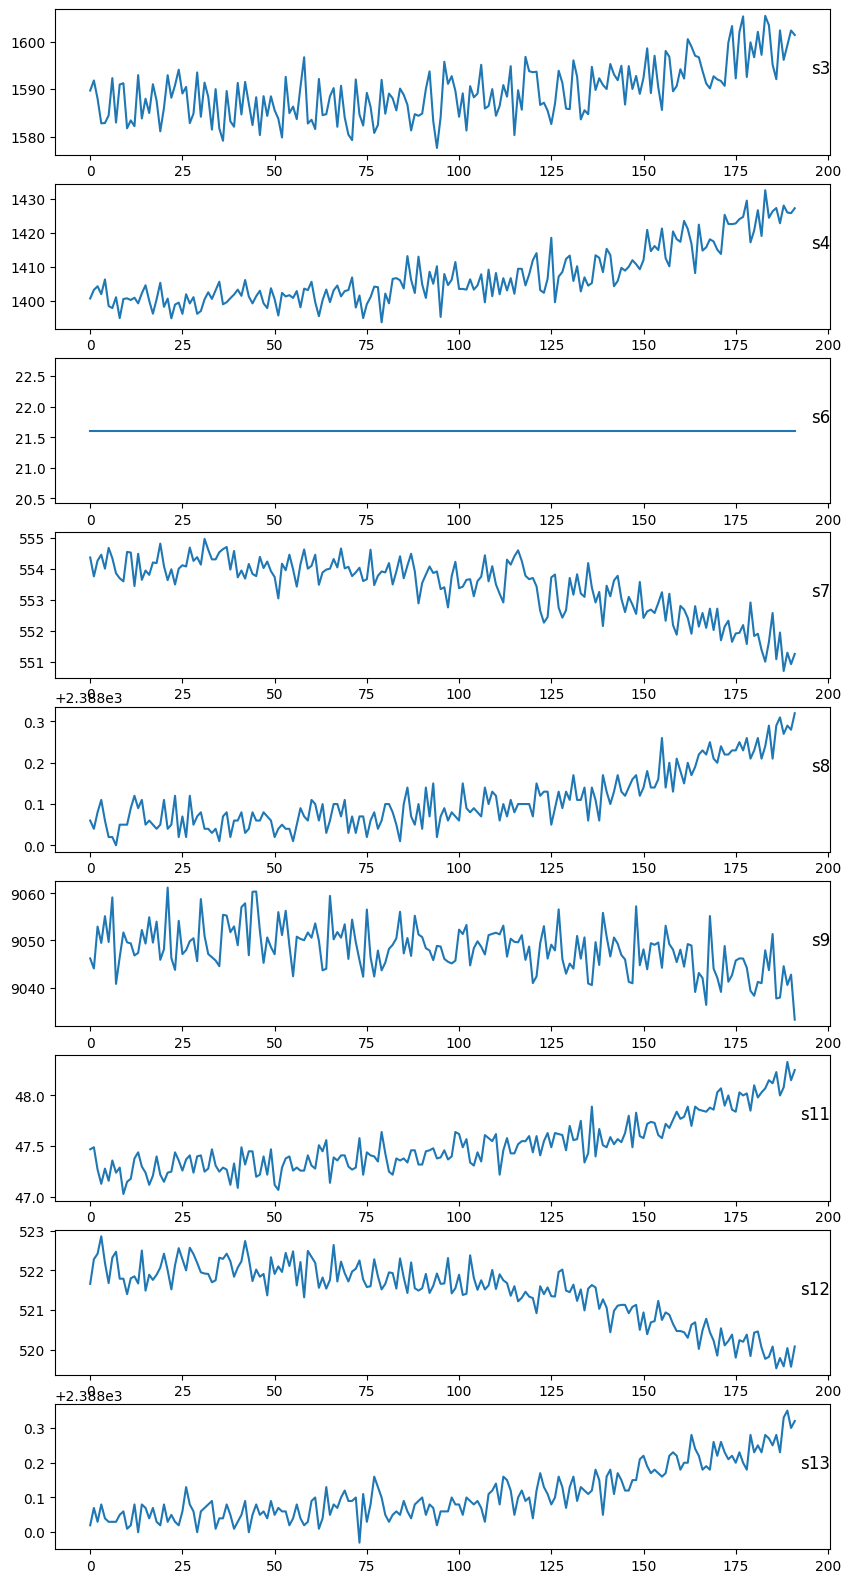

In [27]:
values = train[train.unit==1].values
groups = [5, 6, 7, 8, 9, 10, 11,12,13]
i = 1
plt.figure(figsize=(10,20))
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(train.columns[group], y=0.5, loc='right')
 i += 1
plt.show()

Next, I plot one sensor (`s7`) across multiple units. This helps answer a useful question: do engines follow similar bounds for the same sensor, even if they degrade at different rates?

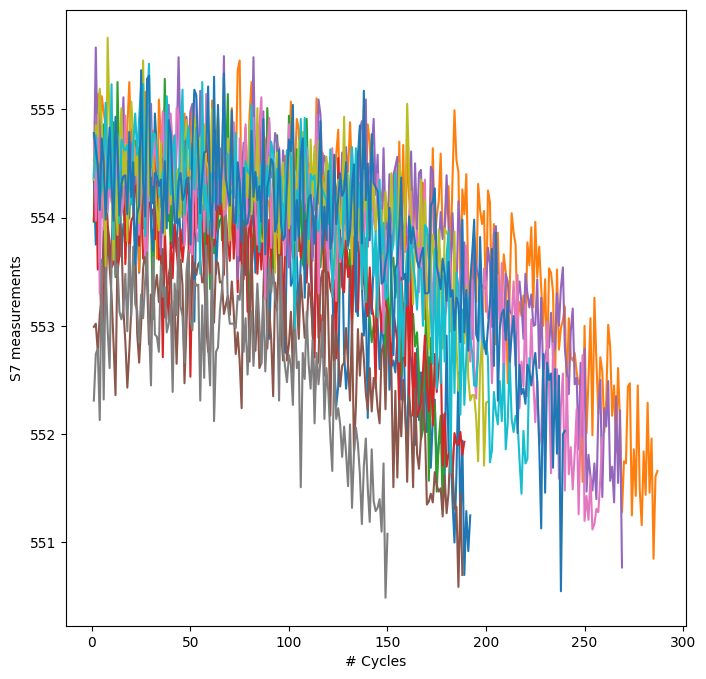

In [28]:
plt.figure(figsize = (8, 8))
plt.plot(train[train.unit==1].cycles, train[train.unit==1].s7)
plt.plot(train[train.unit==2].cycles, train[train.unit==2].s7)
plt.plot(train[train.unit==3].cycles, train[train.unit==3].s7)
plt.plot(train[train.unit==4].cycles, train[train.unit==4].s7)
plt.plot(train[train.unit==5].cycles, train[train.unit==5].s7)
plt.plot(train[train.unit==6].cycles, train[train.unit==6].s7)
plt.plot(train[train.unit==7].cycles, train[train.unit==7].s7)
plt.plot(train[train.unit==8].cycles, train[train.unit==8].s7)
plt.plot(train[train.unit==9].cycles, train[train.unit==9].s7)
plt.plot(train[train.unit==10].cycles, train[train.unit==10].s7)
plt.plot(train[train.unit==11].cycles, train[train.unit==11].s7)
plt.xlabel('# Cycles')
plt.ylabel('S7 measurements')
plt.show()

The signals look noisy, so smoothing or rolling features may help later. I keep that in mind for Data Preparation.

Finally, I test whether different units show similar minima and maxima for a given sensor. I compute min and max per unit for the first ten units, then compare them.

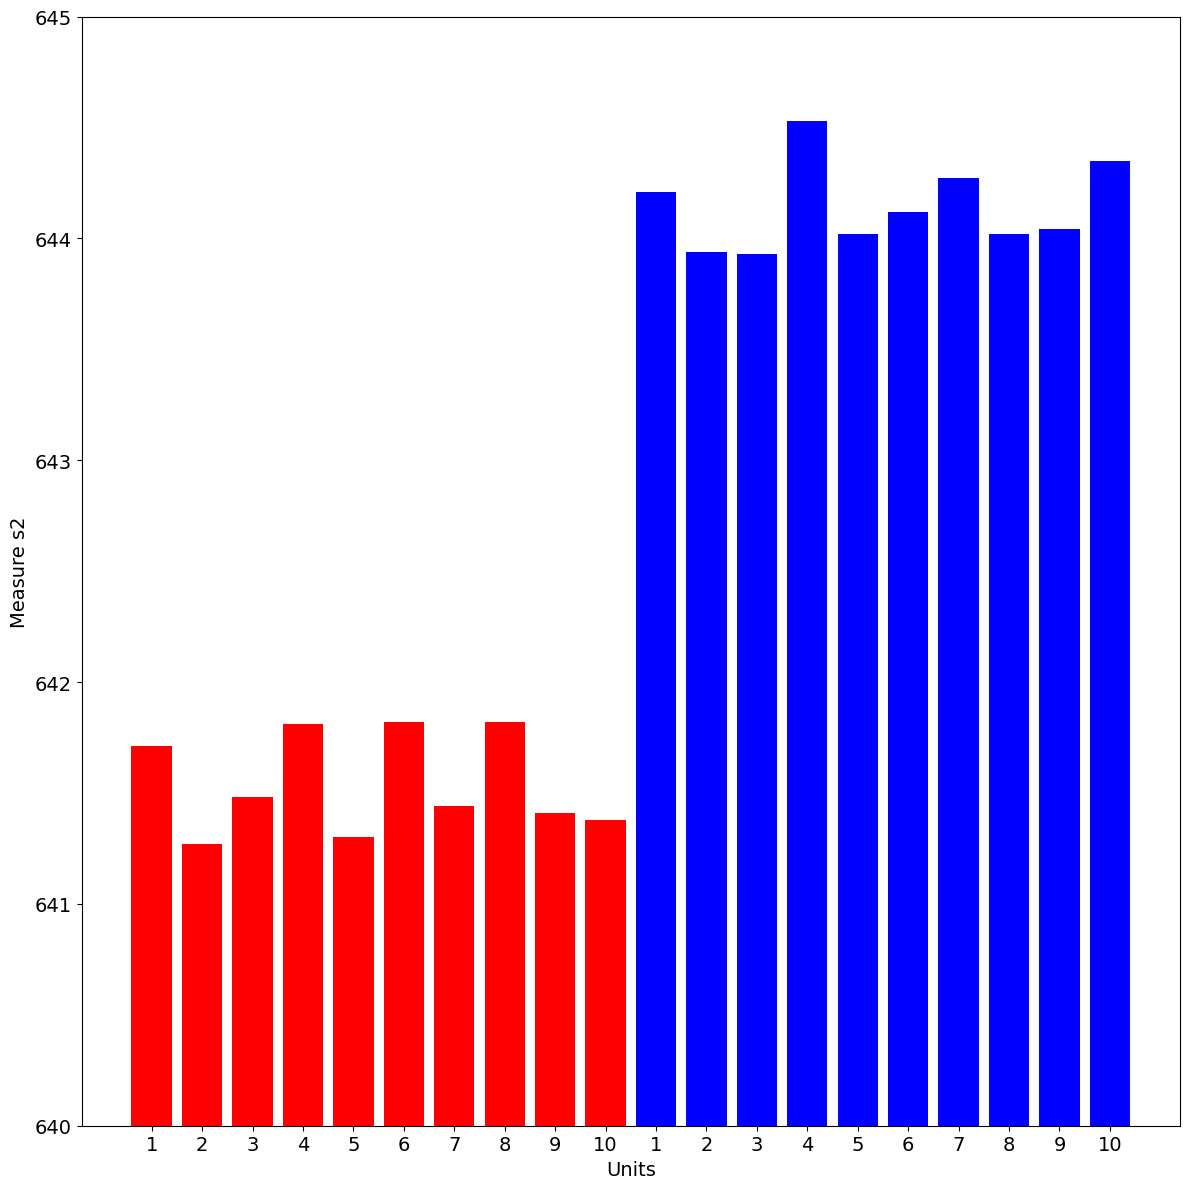

In [29]:
minb = train.groupby('unit', as_index=False).min().head(10)
maxb = train.groupby('unit', as_index=False).max().head(10)

mmtable = pd.concat([minb, maxb], ignore_index=True)

plt.figure(figsize=(12, 12))

col = np.concatenate((np.repeat('red', 10), np.repeat('blue', 10)), axis=0)

bar_labels = list(mmtable['unit'])
x_pos = list(range(len(bar_labels)))

plt.bar(x_pos, mmtable['s2'], color=col)
plt.ylim([640, 645])
plt.xlabel('Units', fontsize=14)
plt.ylabel('Measure s2', fontsize=14)
plt.xticks(x_pos, bar_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

This plot suggests similar bounds across units for at least some sensors, which fits the idea that sensors operate within physical ranges while degradation shifts the trajectory inside those ranges.

At this point, Data Understanding has done its job. I know the structure of the dataset, confirmed missing values are not an issue here, removed flat-line sensors, and got a visual feel for variability, noise, and degradation patterns. Next comes Data Preparation, where I turn these raw time-series into model-friendly features without leaking future information.

# Data Preparation
Data Understanding was us staring at the engine data until it started to stare back. Now Data Preparation is where we turn those raw “engine life snapshots” into something a model can actually learn from, without accidentally teaching it to cheat.

The training set contains full run-to-failure stories, so we can create labels. The test set stops early, so it stays label-free. This section builds the answer key for training (TTF and fTTF), scales the inputs (so sensors stop arguing about units), and then packages everything into X and y.

## Establishing Remaining Useful Life in cycles

Right now the training data knows the whole plot, including the ending. So we can label each row with “how many cycles are left until failure.” The tutorial calls this Time To Failure (TTF). Same idea as RUL, but expressed as “distance from the end” for every snapshot.

First I create a lookup table: for each engine (unit), what is the maximum cycle it reached. This is the “final chapter number” of each engine’s biography. Then I attach that maxcycles value back onto every row of the training set using a transform. This is not magic. This is copy-pasting the final chapter number onto every page of the book so every page can compute “chapters left.”

In [30]:
train['maxcycles'] = train.groupby('unit')['cycles'].transform('max')

Now I compute TTF. If an engine fails at cycle 200, then at cycle 150 it has 50 cycles left. So TTF is simply:

`TTF = maxcycles - cycles`

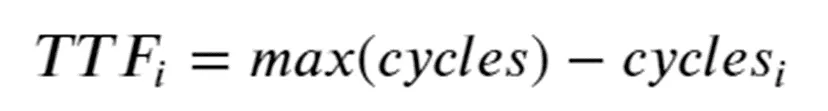

<Axes: xlabel='TTF', ylabel='Count'>

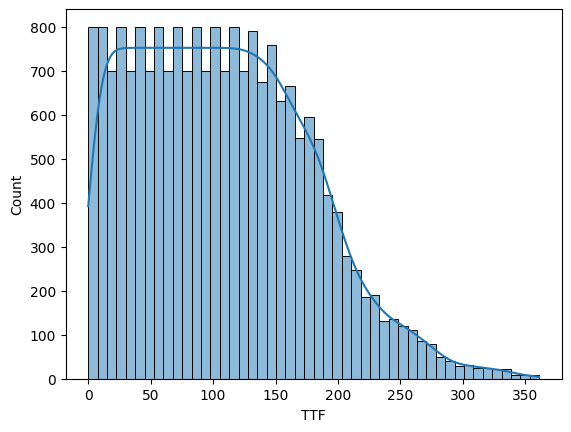

In [31]:
train['TTF'] = train['maxcycles'] - train['cycles']
sns.histplot(train['TTF'], kde=True)

At this point I quickly check if the labels look sane. If TTF is negative, something is cursed. If it has a reasonable range, we continue.

In [32]:
train['TTF'].describe()

count   20631.000
mean      107.808
std        68.881
min         0.000
25%        51.000
50%       103.000
75%       155.000
max       361.000
Name: TTF, dtype: float64

## Scaling
Now we prepare the inputs. Sensor values live in different numeric worlds. One sensor speaks in the 600s, another whispers in decimals. Many models treat bigger numbers as “louder,” which is unfair and also rude.

So I scale the feature columns to a common range using min-max scaling. This compresses each feature into [0, 1] based on what was observed in the training data.

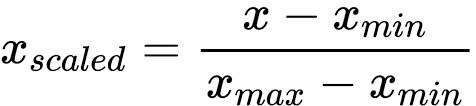

In [33]:
scaler = MinMaxScaler()

In [34]:
train.describe().T

count     mean    std      min      25%      50%      75%  \
unit        20631.000   51.507 29.228    1.000   26.000   52.000   77.000   
cycles      20631.000  108.808 68.881    1.000   52.000  104.000  156.000   
op_setting1 20631.000   -0.000  0.002   -0.009   -0.002    0.000    0.002   
op_setting2 20631.000    0.000  0.000   -0.001   -0.000    0.000    0.000   
s2          20631.000  642.681  0.500  641.210  642.325  642.640  643.000   
s3          20631.000 1590.523  6.131 1571.040 1586.260 1590.100 1594.380   
s4          20631.000 1408.934  9.001 1382.250 1402.360 1408.040 1414.555   
s6          20631.000   21.610  0.001   21.600   21.610   21.610   21.610   
s7          20631.000  553.368  0.885  549.850  552.810  553.440  554.010   
s8          20631.000 2388.097  0.071 2387.900 2388.050 2388.090 2388.140   
s9          20631.000 9065.243 22.083 9021.730 9053.100 9060.660 9069.420   
s11         20631.000   47.541  0.267   46.850   47.350   47.510   47.700   
s12         20631.000  521.413  0.738  518.690  520.960  521.480  521.950   
s13         20631.000 2388.096  0.072 2387.880 2388.040 2388.090 2388.140   
s14         20631.000 8143.753 19.076 8099.940 8133.245 8140.540 8148.310   
s15         20631.000    8.442  0.038    8.325    8.415    8.439    8.466   
s17         20631.000  393.211  1.549  388.000  392.000  393.000  394.000   
s20         20631.000   38.816  0.181   38.140   38.700   38.830   38.950   
s21         20631.000   23.290  0.108   22.894   23.222   23.298   23.367   
maxcycles   20631.000  216.616 50.029  128.000  185.000  207.000  240.000   
TTF         20631.000  107.808 68.881    0.000   51.000  103.000  155.000   

                 max  
unit         100.000  
cycles       362.000  
op_setting1    0.009  
op_setting2    0.001  
s2           644.530  
s3          1616.910  
s4          1441.490  
s6            21.610  
s7           556.060  
s8          2388.560  
s9          9244.590  
s11           48.530  
s12          523.380  
s13         2388.560  
s14         8293.720  
s15            8.585  
s17          400.000  
s20           39.430  
s21           23.618  
maxcycles    362.000  
TTF          361.000

In [35]:
ntrain = train.copy()

In [36]:
cols = ntrain.columns[2:19]
ntrain.loc[:, cols] = ntrain.loc[:, cols].astype("float64")
ntrain.loc[:, cols] = scaler.fit_transform(ntrain.loc[:, cols])

C:\Users\eduar\AppData\Local\Temp\ipykernel_11048\1405647371.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.33333333 0.16666667 ... 0.83333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ntrain.loc[:, cols] = scaler.fit_transform(ntrain.loc[:, cols])


In [37]:
ntrain.describe().T

count    mean    std     min     25%     50%     75%     max
unit        20631.000  51.507 29.228   1.000  26.000  52.000  77.000 100.000
cycles      20631.000 108.808 68.881   1.000  52.000 104.000 156.000 362.000
op_setting1 20631.000   0.499  0.126   0.000   0.414   0.500   0.586   1.000
op_setting2 20631.000   0.502  0.244   0.000   0.333   0.500   0.750   1.000
s2          20631.000   0.443  0.151   0.000   0.336   0.431   0.539   1.000
s3          20631.000   0.425  0.134   0.000   0.332   0.416   0.509   1.000
s4          20631.000   0.450  0.152   0.000   0.339   0.435   0.545   1.000
s6          20631.000   0.980  0.139   0.000   1.000   1.000   1.000   1.000
s7          20631.000   0.566  0.143   0.000   0.477   0.578   0.670   1.000
s8          20631.000   0.298  0.108   0.000   0.227   0.288   0.364   1.000
s9          20631.000   0.195  0.099   0.000   0.141   0.175   0.214   1.000
s11         20631.000   0.411  0.159   0.000   0.298   0.393   0.506   1.000
s12         20631.000   0.581  0.157   0.000   0.484   0.595   0.695   1.000
s13         20631.000   0.318  0.106   0.000   0.235   0.309   0.382   1.000
s14         20631.000   0.226  0.098   0.000   0.172   0.210   0.250   1.000
s15         20631.000   0.451  0.144   0.000   0.346   0.439   0.541   1.000
s17         20631.000   0.434  0.129   0.000   0.333   0.417   0.500   1.000
s20         20631.000   0.524  0.140   0.000   0.434   0.535   0.628   1.000
s21         20631.000   0.546  0.149   0.000   0.452   0.557   0.653   1.000
maxcycles   20631.000 216.616 50.029 128.000 185.000 207.000 240.000 362.000
TTF         20631.000 107.808 68.881   0.000  51.000 103.000 155.000 361.000

In [38]:
ntest = test.copy()

In [39]:
pd.DataFrame(ntest.columns).T

0       1            2            3   4   5   6   7   8   9   10   11  \
0  unit  cycles  op_setting1  op_setting2  s2  s3  s4  s6  s7  s8  s9  s11   

    12   13   14   15   16   17   18  
0  s12  s13  s14  s15  s17  s20  s21

In [40]:
ntest.loc[:, cols] = ntest.loc[:, cols].astype("float64")
ntest.loc[:, cols] = scaler.transform(ntest.loc[:, cols])
ntest.describe().T

C:\Users\eduar\AppData\Local\Temp\ipykernel_11048\3985494543.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.41666667 0.41666667 ... 0.58333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ntest.loc[:, cols] = scaler.transform(ntest.loc[:, cols])


count   mean    std    min    25%    50%     75%     max
unit        13096.000 51.544 28.289  1.000 28.000 52.000  76.000 100.000
cycles      13096.000 76.837 53.058  1.000 33.000 69.000 113.000 303.000
op_setting1 13096.000  0.499  0.127  0.029  0.414  0.500   0.586   0.948
op_setting2 13096.000  0.504  0.245  0.000  0.333  0.500   0.750   1.083
s2          13096.000  0.381  0.121 -0.024  0.297  0.377   0.461   0.931
s3          13096.000  0.372  0.109 -0.044  0.296  0.370   0.443   0.796
s4          13096.000  0.380  0.113  0.036  0.299  0.375   0.452   0.863
s6          13096.000  0.970  0.170  0.000  1.000  1.000   1.000   1.000
s7          13096.000  0.629  0.110  0.166  0.557  0.636   0.707   0.965
s8          13096.000  0.259  0.087 -0.015  0.197  0.258   0.318   0.606
s9          13096.000  0.165  0.051  0.013  0.131  0.160   0.190   0.598
s11         13096.000  0.337  0.117 -0.030  0.250  0.333   0.411   0.839
s12         13096.000  0.652  0.119  0.147  0.574  0.659   0.738   1.081
s13         13096.000  0.281  0.084  0.015  0.221  0.279   0.338   0.647
s14         13096.000  0.201  0.053  0.044  0.167  0.198   0.229   0.622
s15         13096.000  0.388  0.112  0.030  0.311  0.385   0.459   0.833
s17         13096.000  0.381  0.103  0.083  0.333  0.417   0.417   0.750
s20         13096.000  0.583  0.110  0.132  0.512  0.589   0.659   0.984
s21         13096.000  0.610  0.116  0.057  0.535  0.614   0.690   1.032

## Visualizing the scaled data
Scaling should not change the shape of a sensor over time. It should only change the vertical axis numbers. So the pattern should look the same, just “translated into a different language.”

Now I plot one sensor before and after scaling. I use one unit so the comparison is easy to see. This is a technical quality check, not a “peek into the future.”

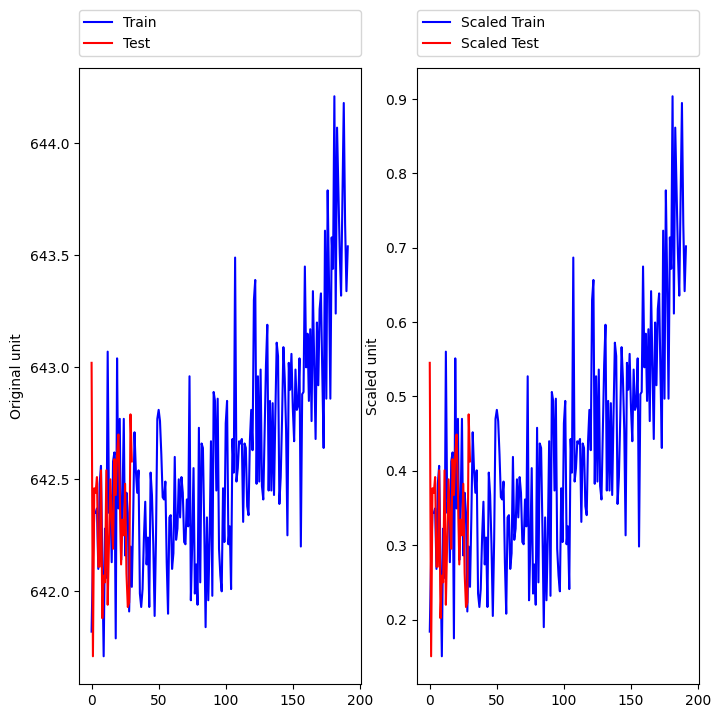

In [41]:
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1,2,1)
plt.plot(train[train.unit==1].s2, color='blue')
plt.plot(test[test.unit==1].s2, color='red')
plt.legend(['Train','Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode='expand', borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(ntrain[ntrain.unit==1].s2, color='blue')
plt.plot(ntest[ntest.unit==1].s2, color='red')
plt.legend(['Scaled Train','Scaled Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode='expand', borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

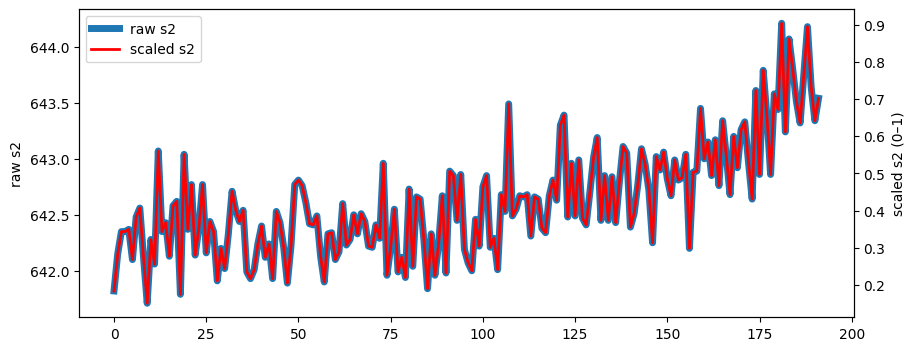

In [42]:
raw = train.loc[train.unit == 1, "s2"].to_numpy()
scaled = ntrain.loc[ntrain.unit == 1, "s2"].to_numpy()

fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.plot(raw, label="raw s2", linewidth=5)                 
ax2.plot(scaled, label="scaled s2", linewidth=2, color="red") 

ax1.set_ylabel("raw s2")
ax2.set_ylabel("scaled s2 (0–1)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.show()

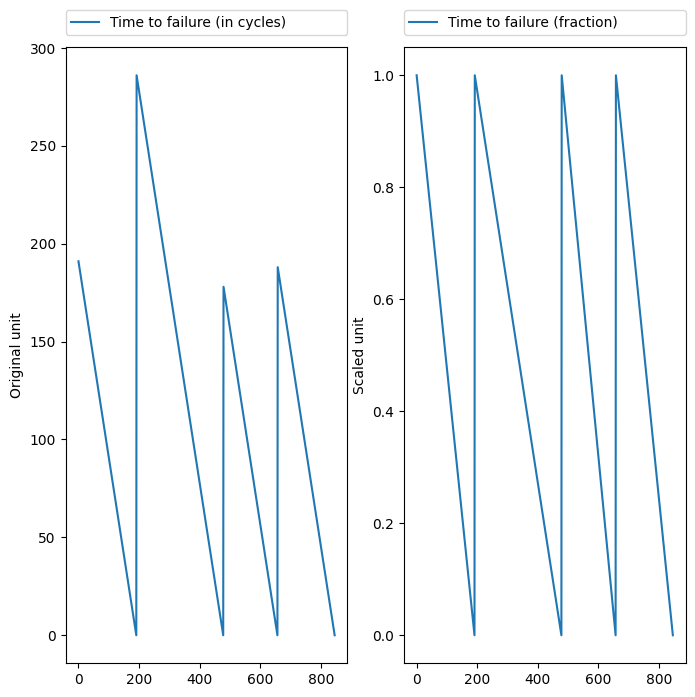

In [43]:
def fractionTTF(dat, q):
    return (dat.TTF[q] - dat.TTF.min()) / float(dat.TTF.max() - dat.TTF.min())

fTTF = []

for i in range(train['unit'].min(), train['unit'].max() + 1):
    dat = train[train.unit == i].reset_index(drop=True)

    for q in range(len(dat)):
        fTTF.append(fractionTTF(dat, q))

ntrain['fTTF'] = fTTF

mx = cyclestrain.iloc[0:4, 1].sum()

fig = plt.figure(figsize=(8, 8))

fig.add_subplot(1, 2, 1)
plt.plot(ntrain.TTF[0:mx])
plt.legend(
    ['Time to failure (in cycles)'],
    bbox_to_anchor=(0., 1.02, 1., .102),
    loc=3,
    mode="expand",
    borderaxespad=0
)
plt.ylabel('Original unit')

fig.add_subplot(1, 2, 2)
plt.plot(ntrain.fTTF[0:mx])
plt.legend(
    ['Time to failure (fraction)'],
    bbox_to_anchor=(0., 1.02, 1., .102),
    loc=3,
    mode="expand",
    borderaxespad=0
)
plt.ylabel('Scaled unit')

plt.show()


If the two plots have the same ups and downs, scaling did its job. If the pattern looks distorted, something went wrong in column selection or transformation.

## Fraction Time-To-Failure (fTTF)
TTF is measured in cycles, but engines have different total lifetimes. Some engines fail early, some keep going. If I want a target that behaves like a consistent “health bar,” I can normalize TTF per engine.

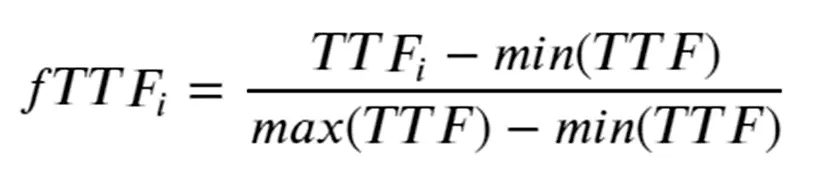

This fraction starts at 1.0 early in the engine’s life and goes down to 0.0 at failure. Same story, different scale.

Instead of looping through every unit and row, I compute it with a group operation. Less code, fewer tears.

First I compute, for each row, the maximum TTF inside that unit. That value is the starting TTF for that engine (the “full health” moment). Then convert TTF into a fraction. Since the minimum TTF is 0 at failure, this becomes a clean ratio.

In [44]:
ntrain['fTTF'] = ntrain['TTF'] / ntrain.groupby('unit')['TTF'].transform('max')

In [45]:
ntrain["fTTF"].describe()

count   20631.000
mean        0.500
std         0.290
min         0.000
25%         0.249
50%         0.500
75%         0.751
max         1.000
Name: fTTF, dtype: float64

In [46]:
check_unit = 1
u = ntrain[ntrain.unit == check_unit]

print("fTTF start (should be close to 1):", u['fTTF'].iloc[0])
print("fTTF end (should be 0):", u['fTTF'].iloc[-1])

fTTF start (should be close to 1): 1.0
fTTF end (should be 0): 0.0


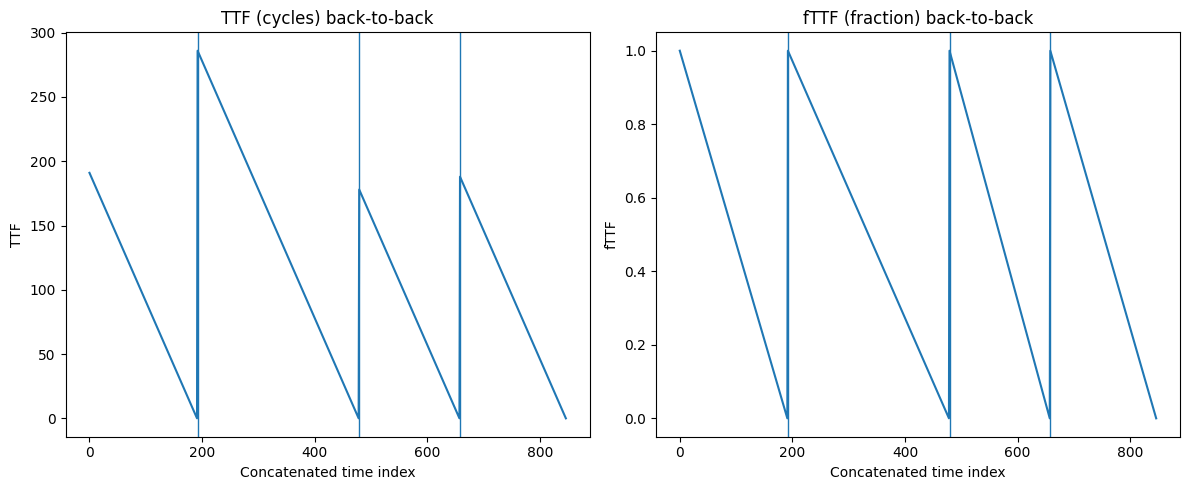

In [47]:
# Use ntrain if it contains both TTF and fTTF (recommended).
df = ntrain.copy()

# Pick first k units (change k if you want more/less)
k = 4
units = sorted(df["unit"].unique())[:k]

# Build back-to-back sequences
ttf_all = []
fttf_all = []
boundaries = [0]

for u in units:
    u_df = df[df["unit"] == u].sort_values("cycles")
    ttf_all.extend(u_df["TTF"].to_numpy())
    fttf_all.extend(u_df["fTTF"].to_numpy())
    boundaries.append(len(ttf_all))

# Plot zigzags (concatenated units)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=False)

ax1.plot(ttf_all)
ax1.set_title("TTF (cycles) back-to-back")
ax1.set_xlabel("Concatenated time index")
ax1.set_ylabel("TTF")

ax2.plot(fttf_all)
ax2.set_title("fTTF (fraction) back-to-back")
ax2.set_xlabel("Concatenated time index")
ax2.set_ylabel("fTTF")

# Draw vertical separators between units
for b in boundaries[1:-1]:
    ax1.axvline(b, linewidth=1)
    ax2.axvline(b, linewidth=1)

plt.tight_layout()
plt.show()

If you plot TTF and fTTF for a few units back-to-back, you will get that “zigzag” effect. That is not the engines being dramatic. That is just multiple engine timelines concatenated into one long line.

## Packaging data for the model: X_train, y_train, X_test
Now I prepare the arrays for scikit-learn. The model wants two things: a feature matrix `x` and a target vector `y`.

- `X_train` is the scaled snapshot data (cycles, settings, sensors).
- `y_train` is the answer key (here: fTTF).
- `X_test` is the scaled snapshot data for the test set.

In [48]:
pd.DataFrame(ntrain.columns).T

0       1            2            3   4   5   6   7   8   9   ...   12  \
0  unit  cycles  op_setting1  op_setting2  s2  s3  s4  s6  s7  s8  ...  s12   

    13   14   15   16   17   18         19   20    21  
0  s13  s14  s15  s17  s20  s21  maxcycles  TTF  fTTF  

[1 rows x 22 columns]

In [49]:
for idx, col in enumerate(ntrain.columns):
    print(idx, col)


0 unit
1 cycles
2 op_setting1
3 op_setting2
4 s2
5 s3
6 s4
7 s6
8 s7
9 s8
10 s9
11 s11
12 s12
13 s13
14 s14
15 s15
16 s17
17 s20
18 s21
19 maxcycles
20 TTF
21 fTTF


In [50]:
feature_cols = ntrain.columns[1:19] 
X_train = ntrain.loc[:, feature_cols].to_numpy()
Y_train = ntrain['fTTF'].to_numpy()

X_test = ntest.loc[:, feature_cols].to_numpy()

In [51]:
print("Features:", list(feature_cols))
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)

Features: ['cycles', 'op_setting1', 'op_setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
X_train shape: (20631, 18)
Y_train shape: (20631,)
X_test shape: (13096, 18)


At this point, the dataset is in “model-ready” form. Each row is one engine snapshot. The features describe what the engine looks like at that cycle. The target tells how close it is to failure, expressed as a normalized health bar.

Next, in the Modeling phase, I can train a regressor to predict fTTF from the scaled sensor data. Then later, I can convert those predictions back into cycle-based RUL when I want to compare against the provided `RUL_target.txt`.

# Modeling
In the previous step, we turned engine biographies into training examples. Each row is one snapshot. Each snapshot has scaled sensor features. Each snapshot also has a target label.

Important reminder before we touch any model: the target we trained on is not “cycles left.” It is fTTF, a fraction between 1 and 0. Full health bar at the start. Empty health bar at failure.

## Random Forest model fitting 
A Random Forest is a committee of decision trees. Each tree is a slightly opinionated intern asking questions like “Is s7 above 0.43?” or “Is cycle below 0.61?” and then guessing a number. One tree can be dramatic. A whole forest averages the drama. Now I train the model.

In [52]:
regressor = RandomForestRegressor()
regressor.fit(X_train, Y_train)

RandomForestRegressor()

Conceptually, the forest is learning a mapping:

- scaled features at a given cycle → predicted fTTF

So later, when we call predict, the output should live on the same 0–1 scale.

## Predict test score (fraction remaining life from 1.00 to 0.00)
Now I generate predictions for every row in the test set. That means every snapshot of every engine in the test file gets a predicted health bar value.

In [53]:
score = regressor.predict(X_test)
score[0:10]

array([1.        , 0.99553776, 0.98981129, 0.98455327, 0.97968325,
       0.97433142, 0.96813378, 0.96517958, 0.95975145, 0.95609578])

In [54]:
print(score.min(), score.max())

0.016561188503836654 1.0


If the training labels live in [0,1], a Random Forest usually stays in [0,1] too, because it averages labels from training samples. The only annoying detail is that it can output exactly 1.0. That becomes a problem later because the conversion formula contains (1 - score) in the denominator. So I add a safety copy in case the equation explodes. 

In [55]:
eps = 1e-6
score_safe = np.clip(score, 0.0, 1.0 - eps)
print(score_safe.min(), score_safe.max())

0.016561188503836654 0.999999


You can think of this as putting a tiny bumper on the bowling lane. The ball can still roll. It stops falling into the “divide by zero” gutter.

## Converting the fraction back into cycles
This is the part that looks like wizardry until you write the algebra once.

In training, for an engine that fails at `total_cycles`, we had:

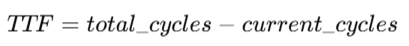

Then we defined a fraction remaining life:

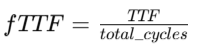

Substitute the first equation into the second:

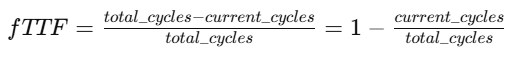

Rearrange to solve for total cycles:

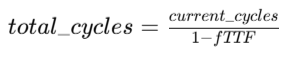

In test, we do not know `total_cycles`, so we estimate it using the model’s predicted fraction.

Now we need `maxcycles` in the test set, meaning the last recorded cycle for each unit (not failure, only the last observed point). I compute it with `transform`, so the row order stays unchanged and predictions stay aligned.

In [56]:
test = test.copy()
test["maxcycles"] = test.groupby("unit")["cycles"].transform("max")
test["score"] = score
test.head()

unit  cycles  op_setting1  op_setting2      s2       s3       s4     s6  \
0     1       1        0.002        0.000 643.020 1585.290 1398.210 21.610   
1     1       2       -0.003       -0.000 641.710 1588.450 1395.420 21.610   
2     1       3        0.000        0.000 642.460 1586.940 1401.340 21.610   
3     1       4        0.004        0.000 642.440 1584.120 1406.420 21.610   
4     1       5        0.001        0.000 642.510 1587.190 1401.920 21.610   

       s7       s8  ...    s11     s12      s13      s14   s15  s17    s20  \
0 553.900 2388.040  ... 47.200 521.720 2388.030 8125.550 8.405  392 38.860   
1 554.850 2388.010  ... 47.500 522.160 2388.060 8139.620 8.380  393 39.020   
2 554.110 2388.050  ... 47.500 521.970 2388.030 8130.100 8.444  393 39.080   
3 554.070 2388.030  ... 47.280 521.380 2388.050 8132.900 8.392  391 39.000   
4 554.160 2388.010  ... 47.310 522.150 2388.030 8129.540 8.403  390 38.990   

     s21  maxcycles  score  
0 23.373         31  1.000  
1 23.392         31  0.996  
2 23.417         31  0.990  
3 23.374         31  0.985  
4 23.413         31  0.980  

[5 rows x 21 columns]

In [57]:
test = test.copy()
test['maxcycles'] = test.groupby('unit')['cycles'].transform('max')

# assign score in a way that guarantees alignment to the same row order used for X_test
test['score'] = score_safe

Now I compute “predicted total life” for each row using the inversion formula:

In [58]:
def totcycles(data):
    return (data['cycles'] / (1 - data['score']))

test['maxpredcycles'] = totcycles(test)

Now I convert predicted total cycles into predicted remaining cycles (RUL). The logic is:

predicted remaining cycles = predicted total cycles − last observed cycle

The last observed cycle is maxcycles for that unit.

In [59]:
def RULfunction(data):
    return (data['maxpredcycles'] - data['maxcycles'])

test['RUL'] = RULfunction(test)

In [60]:
test['RUL'].head()

0   999969.000
1      417.205
2      263.443
3      227.954
4      215.102
Name: RUL, dtype: float64

At this stage, you still have a predicted RUL for every row, which is not what the dataset evaluates.

## One RUL per engine (the only one that matters)
The official evaluation expects one RUL value per engine in the test set, at the last recorded cycle of that engine. That is the final snapshot we have. That is where we answer the business question: “How many cycles are left after this point?”

So I keep only the last row per unit.

In [61]:
test_last = test.sort_values(['unit', 'cycles']).groupby('unit', as_index=False).tail(1)

# one prediction per unit:
rul_per_unit = test_last[['unit', 'cycles', 'score', 'RUL']].sort_values('unit').reset_index(drop=True)
rul_per_unit.head()

unit  cycles  score     RUL
0     1      31  0.852 178.882
1     2      49  0.755 150.608
2     3     126  0.294  52.394
3     4     106  0.462  90.866
4     5      98  0.508 101.066

Now `rul_per_unit` is the proper output: one prediction per engine.

If you want a quick sanity check, RUL should often be non-negative. Negative values can happen if the model predicts an engine “already past failure,” which is physically awkward, but it can also be a sign the conversion became unstable.

## A parallel model in the same format: Extra Trees
Random Forest is solid, but we can add a second contestant that fits the same tabular setup. Extra Trees is like Random Forest’s chaotic cousin. It injects more randomness in how it splits, and on many tabular problems it performs surprisingly well.

In [62]:
regressor_et = ExtraTreesRegressor(
    n_estimators=600,
    random_state=42,
    n_jobs=-1
)
regressor_et.fit(X_train, Y_train)

score_et = regressor_et.predict(X_test)
score_et = np.clip(score_et, 0.0, 1.0 - 1e-6)

test_et = test.copy()
test_et['score'] = score_et
test_et['maxpredcycles'] = totcycles(test_et)
test_et['RUL'] = RULfunction(test_et)

test_et_last = test_et.sort_values(['unit', 'cycles']).groupby('unit', as_index=False).tail(1)
rul_per_unit_et = test_et_last[['unit', 'cycles', 'score', 'RUL']].sort_values('unit').reset_index(drop=True)

rul_per_unit_et.head()

unit  cycles  score     RUL
0     1      31  0.845 169.646
1     2      49  0.753 149.066
2     3     126  0.303  54.888
3     4     106  0.427  79.113
4     5      98  0.508 101.354

Now you have two sets of predictions per engine: one from Random Forest and one from Extra Trees. In the next phase (Evaluation), you compare these against the ground-truth RUL file and see which model behaves better, not only by error metrics but also by whether the predictions look physically reasonable.